In [267]:
import pandas as pd
import numpy as np
from numpy import unique
from numpy import where
import matplotlib.pyplot as plt
import sys
import math
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import chi2_contingency
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import Birch
from sklearn import metrics
from scipy import stats
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.datasets import make_classification
from matplotlib import pyplot

In [268]:
def myround(x, base=5):
    return base * round(float(x) / base)

In [269]:
facilities = pd.read_csv("facilities.csv",encoding='latin-1')
facilities

,nyt_id,facility_name,facility_type,facility_city,facility_county,facility_county_fips,facility_state,facility_lng,facility_lat,latest_inmate_population,max_inmate_population_2020,total_inmate_cases,total_inmate_deaths,total_officer_cases,total_officer_deaths,note
0,F3EFE858,Alex City Work Release prison,Low-security work release,Alex City,Coosa,1037,Alabama,-86.009015,32.904507,188.0,NaN,77,0,17,0.0,NaN
1,5B910220,Alabama Therapeutic Education Facility prison,State rehabilitation center,Columbiana,Shelby,1117,Alabama,-86.624067,33.180755,272.0,NaN,11,1,2,0.0,NaN
2,02FB1675,Bibb Correctional Facility,State prison,Brent,Bibb,1007,Alabama,-87.162781,32.920754,1725.0,1825.0,164,3,61,0.0,NaN
3,6378F6C4,Birmingham Women's Community Based Facility an...,State prison,Birmingham,Jefferson,1073,Alabama,-86.808344,33.531101,192.0,NaN,17,0,28,0.0,NaN
4,EAABF900,Bullock Correctional Facility,State prison,Bessemer,Bullock,1011,Alabama,-85.673927,32.147144,1477.0,1577.0,162,5,80,1.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2634,15289545,North Lake federal prison,Federal prison,Baldwin,Lake,26085,Michigan,-85.839287,43.928551,1614.0,1614.0,125,2,0,0.0,NaN
2635,1558C2BF,Rivers federal prison,Federal prison,Winton,Hertford,37091,North Carolina,-76.958751,36.403668,6.0,1255.0,68,1,0,0.0,NaN
2636,C9CF62B9,Reeves County federal prison,Federal prison,Pecos,Reeves,48389,Texas,-103.493817,31.423563,1005.0,NaN,46,1,0,0.0,NaN
2637,364869B9,Flightline federal prison,Federal prison,Big Spring,Howard,48227,Texas,-101.521236,32.224310,1652.0,NaN,34,1,0,0.0,NaN


In [270]:
facilities = facilities.dropna(subset=['latest_inmate_population'])
facilities = facilities.reset_index(drop = True)

facilities['capacity'] = 1
facilities['capacity'] = facilities.apply(lambda x: float("nan") if (math.isnan(x.max_inmate_population_2020)) or (math.isnan(x.latest_inmate_population)) else int(x.latest_inmate_population / x.max_inmate_population_2020 * 100) / 100, axis = 1)
#display(facilities)
t = facilities['facility_type'].value_counts(normalize=True)
#display(t)
s = facilities['capacity'].value_counts(normalize=True)
#display(s)
facilities['capacity_nan'] = facilities['capacity']

facilities.loc[facilities['capacity'].isna(), 'capacity_nan'] = np.random.choice(s.index, p=s.values, size=facilities['capacity'].isna().sum())
#display(facilities.sort_values(by=['capacity_nan']))
facilities.max_inmate_population_2020 = facilities.apply(lambda x: x.max_inmate_population_2020 if math.isnan(x.capacity_nan) or x.capacity_nan == 0 else x.latest_inmate_population / x.capacity_nan, axis = 1)
facilities = facilities.dropna(subset=['max_inmate_population_2020'])

facilities.max_inmate_population_2020 = facilities.max_inmate_population_2020.astype(int)
#display(facilities.sort_values(by=['capacity_nan']))

t = facilities['facility_type'].value_counts(normalize=True)
#display(t)
facilities

,nyt_id,facility_name,facility_type,facility_city,facility_county,facility_county_fips,facility_state,facility_lng,facility_lat,latest_inmate_population,max_inmate_population_2020,total_inmate_cases,total_inmate_deaths,total_officer_cases,total_officer_deaths,note,capacity,capacity_nan
0,F3EFE858,Alex City Work Release prison,Low-security work release,Alex City,Coosa,1037,Alabama,-86.009015,32.904507,188.0,211,77,0,17,0.0,NaN,NaN,0.89
1,5B910220,Alabama Therapeutic Education Facility prison,State rehabilitation center,Columbiana,Shelby,1117,Alabama,-86.624067,33.180755,272.0,320,11,1,2,0.0,NaN,NaN,0.85
2,02FB1675,Bibb Correctional Facility,State prison,Brent,Bibb,1007,Alabama,-87.162781,32.920754,1725.0,1835,164,3,61,0.0,NaN,0.94,0.94
3,6378F6C4,Birmingham Women's Community Based Facility an...,State prison,Birmingham,Jefferson,1073,Alabama,-86.808344,33.531101,192.0,192,17,0,28,0.0,NaN,NaN,1.00
4,EAABF900,Bullock Correctional Facility,State prison,Bessemer,Bullock,1011,Alabama,-85.673927,32.147144,1477.0,1588,162,5,80,1.0,NaN,0.93,0.93
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1588,15289545,North Lake federal prison,Federal prison,Baldwin,Lake,26085,Michigan,-85.839287,43.928551,1614.0,1614,125,2,0,0.0,NaN,1.00,1.00
1589,1558C2BF,Rivers federal prison,Federal prison,Winton,Hertford,37091,North Carolina,-76.958751,36.403668,6.0,1255,68,1,0,0.0,NaN,0.00,0.00
1590,C9CF62B9,Reeves County federal prison,Federal prison,Pecos,Reeves,48389,Texas,-103.493817,31.423563,1005.0,1305,46,1,0,0.0,NaN,NaN,0.77
1591,364869B9,Flightline federal prison,Federal prison,Big Spring,Howard,48227,Texas,-101.521236,32.224310,1652.0,1815,34,1,0,0.0,NaN,NaN,0.91


In [271]:
facilities['lng_round'] = facilities.apply(lambda x: myround(x.facility_lng), axis = 1)
facilities['lat_round'] = facilities.apply(lambda x: myround(x.facility_lat), axis = 1)

facilities = facilities.drop(['note'], axis=1)
facilities['capacity']     = facilities['capacity'].fillna(0)
facilities['capacity_nan'] = facilities['capacity_nan'].fillna(0)

facilities['capacity_all']  = facilities['capacity'] + facilities['capacity_nan']
#facilities.to_csv('First_prepro.csv', index=False)
facilities

,nyt_id,facility_name,facility_type,facility_city,facility_county,facility_county_fips,facility_state,facility_lng,facility_lat,latest_inmate_population,max_inmate_population_2020,total_inmate_cases,total_inmate_deaths,total_officer_cases,total_officer_deaths,capacity,capacity_nan,lng_round,lat_round,capacity_all
0,F3EFE858,Alex City Work Release prison,Low-security work release,Alex City,Coosa,1037,Alabama,-86.009015,32.904507,188.0,211,77,0,17,0.0,0.00,0.89,-85,35,0.89
1,5B910220,Alabama Therapeutic Education Facility prison,State rehabilitation center,Columbiana,Shelby,1117,Alabama,-86.624067,33.180755,272.0,320,11,1,2,0.0,0.00,0.85,-85,35,0.85
2,02FB1675,Bibb Correctional Facility,State prison,Brent,Bibb,1007,Alabama,-87.162781,32.920754,1725.0,1835,164,3,61,0.0,0.94,0.94,-85,35,1.88
3,6378F6C4,Birmingham Women's Community Based Facility an...,State prison,Birmingham,Jefferson,1073,Alabama,-86.808344,33.531101,192.0,192,17,0,28,0.0,0.00,1.00,-85,35,1.00
4,EAABF900,Bullock Correctional Facility,State prison,Bessemer,Bullock,1011,Alabama,-85.673927,32.147144,1477.0,1588,162,5,80,1.0,0.93,0.93,-85,30,1.86
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1588,15289545,North Lake federal prison,Federal prison,Baldwin,Lake,26085,Michigan,-85.839287,43.928551,1614.0,1614,125,2,0,0.0,1.00,1.00,-85,45,2.00
1589,1558C2BF,Rivers federal prison,Federal prison,Winton,Hertford,37091,North Carolina,-76.958751,36.403668,6.0,1255,68,1,0,0.0,0.00,0.00,-75,35,0.00
1590,C9CF62B9,Reeves County federal prison,Federal prison,Pecos,Reeves,48389,Texas,-103.493817,31.423563,1005.0,1305,46,1,0,0.0,0.00,0.77,-105,30,0.77
1591,364869B9,Flightline federal prison,Federal prison,Big Spring,Howard,48227,Texas,-101.521236,32.224310,1652.0,1815,34,1,0,0.0,0.00,0.91,-100,30,0.91


In [272]:
values = {"latest_inmate_population": 1}
facilities.fillna(value=values)
facilities.capacity = facilities.apply(lambda x: float("nan") if (math.isnan(x.max_inmate_population_2020)) or (math.isnan(x.latest_inmate_population)) else int(x.latest_inmate_population / x.max_inmate_population_2020 * 100) / 100, axis = 1)

s = facilities.capacity.value_counts(normalize=True)
facilities.capacity_nan= facilities.capacity
facilities.loc[facilities.capacity.isna(), 'capacity_nan'] = np.random.choice(s.index, p=s.values, size=facilities.capacity.isna().sum())
#display(facilities.sort_values(by=['capacity_nan']))
facilities.max_inmate_population_2020 = facilities.apply(lambda x: x.max_inmate_population_2020 if math.isnan(x.capacity_nan) or x.capacity_nan == 0 else x.latest_inmate_population / x.capacity_nan, axis = 1)
facilities = facilities.dropna(subset=['max_inmate_population_2020'])
facilities.max_inmate_population_2020 = facilities.max_inmate_population_2020.astype(int)
#display(facilities.sort_values(by=['capacity_nan']))

facilities.facility_lat = (facilities.facility_lat * 10).astype(int) / 10
facilities.facility_lng = (facilities.facility_lng * 10).astype(int) / 10
#facilities = facilities.drop(['note'], axis=1)

facilities

,nyt_id,facility_name,facility_type,facility_city,facility_county,facility_county_fips,facility_state,facility_lng,facility_lat,latest_inmate_population,max_inmate_population_2020,total_inmate_cases,total_inmate_deaths,total_officer_cases,total_officer_deaths,capacity,capacity_nan,lng_round,lat_round,capacity_all
0,F3EFE858,Alex City Work Release prison,Low-security work release,Alex City,Coosa,1037,Alabama,-86.0,32.9,188.0,211,77,0,17,0.0,0.89,0.89,-85,35,0.89
1,5B910220,Alabama Therapeutic Education Facility prison,State rehabilitation center,Columbiana,Shelby,1117,Alabama,-86.6,33.1,272.0,320,11,1,2,0.0,0.85,0.85,-85,35,0.85
2,02FB1675,Bibb Correctional Facility,State prison,Brent,Bibb,1007,Alabama,-87.1,32.9,1725.0,1835,164,3,61,0.0,0.94,0.94,-85,35,1.88
3,6378F6C4,Birmingham Women's Community Based Facility an...,State prison,Birmingham,Jefferson,1073,Alabama,-86.8,33.5,192.0,192,17,0,28,0.0,1.00,1.00,-85,35,1.00
4,EAABF900,Bullock Correctional Facility,State prison,Bessemer,Bullock,1011,Alabama,-85.6,32.1,1477.0,1588,162,5,80,1.0,0.93,0.93,-85,30,1.86
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1588,15289545,North Lake federal prison,Federal prison,Baldwin,Lake,26085,Michigan,-85.8,43.9,1614.0,1614,125,2,0,0.0,1.00,1.00,-85,45,2.00
1589,1558C2BF,Rivers federal prison,Federal prison,Winton,Hertford,37091,North Carolina,-76.9,36.4,6.0,1255,68,1,0,0.0,0.00,0.00,-75,35,0.00
1590,C9CF62B9,Reeves County federal prison,Federal prison,Pecos,Reeves,48389,Texas,-103.4,31.4,1005.0,1305,46,1,0,0.0,0.77,0.77,-105,30,0.77
1591,364869B9,Flightline federal prison,Federal prison,Big Spring,Howard,48227,Texas,-101.5,32.2,1652.0,1815,34,1,0,0.0,0.91,0.91,-100,30,0.91


In [273]:
mydata = facilities.copy()

# Takes down the last lines with null
mydata = mydata.dropna(subset = mydata.columns.values[:-2]).reset_index(drop = True)

# add relevant features
mydata['ratio_cases_inmate']   = mydata['total_inmate_cases']   / mydata['max_inmate_population_2020']
mydata['ratio_deaths_inmate']  = mydata['total_inmate_deaths']  / mydata['max_inmate_population_2020']
mydata['ratio_cases_officer']  = mydata['total_officer_cases']  / mydata['max_inmate_population_2020']
mydata['ratio_deaths_officer'] = mydata['total_officer_deaths'] / mydata['max_inmate_population_2020']

# Make a copy for after analysis
data_before_encoding = mydata.copy()

#Removes the columns that are not relevant for preliminary analysis
mydata = mydata.drop(columns = ['nyt_id' , 'capacity' , 'capacity_nan' , 'facility_county_fips' , 'lat_round' , 'lng_round'])

# Create a copy for future data conversion
mydata_convert = mydata.copy()

mydata

,facility_name,facility_type,facility_city,facility_county,facility_state,facility_lng,facility_lat,latest_inmate_population,max_inmate_population_2020,total_inmate_cases,total_inmate_deaths,total_officer_cases,total_officer_deaths,capacity_all,ratio_cases_inmate,ratio_deaths_inmate,ratio_cases_officer,ratio_deaths_officer
0,Alex City Work Release prison,Low-security work release,Alex City,Coosa,Alabama,-86.0,32.9,188.0,211,77,0,17,0.0,0.89,0.364929,0.000000,0.080569,0.00000
1,Alabama Therapeutic Education Facility prison,State rehabilitation center,Columbiana,Shelby,Alabama,-86.6,33.1,272.0,320,11,1,2,0.0,0.85,0.034375,0.003125,0.006250,0.00000
2,Bibb Correctional Facility,State prison,Brent,Bibb,Alabama,-87.1,32.9,1725.0,1835,164,3,61,0.0,1.88,0.089373,0.001635,0.033243,0.00000
3,Birmingham Women's Community Based Facility an...,State prison,Birmingham,Jefferson,Alabama,-86.8,33.5,192.0,192,17,0,28,0.0,1.00,0.088542,0.000000,0.145833,0.00000
4,Bullock Correctional Facility,State prison,Bessemer,Bullock,Alabama,-85.6,32.1,1477.0,1588,162,5,80,1.0,1.86,0.102015,0.003149,0.050378,0.00063
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1584,North Lake federal prison,Federal prison,Baldwin,Lake,Michigan,-85.8,43.9,1614.0,1614,125,2,0,0.0,2.00,0.077447,0.001239,0.000000,0.00000
1585,Rivers federal prison,Federal prison,Winton,Hertford,North Carolina,-76.9,36.4,6.0,1255,68,1,0,0.0,0.00,0.054183,0.000797,0.000000,0.00000
1586,Reeves County federal prison,Federal prison,Pecos,Reeves,Texas,-103.4,31.4,1005.0,1305,46,1,0,0.0,0.77,0.035249,0.000766,0.000000,0.00000
1587,Flightline federal prison,Federal prison,Big Spring,Howard,Texas,-101.5,32.2,1652.0,1815,34,1,0,0.0,0.91,0.018733,0.000551,0.000000,0.00000


In [ ]:
#pre analysis

facility_name :


C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 128 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 147 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 153 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 139 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:203: RuntimeWarning: Glyph 128 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:203: RuntimeWarning: Glyph 147 missing from current font.
 

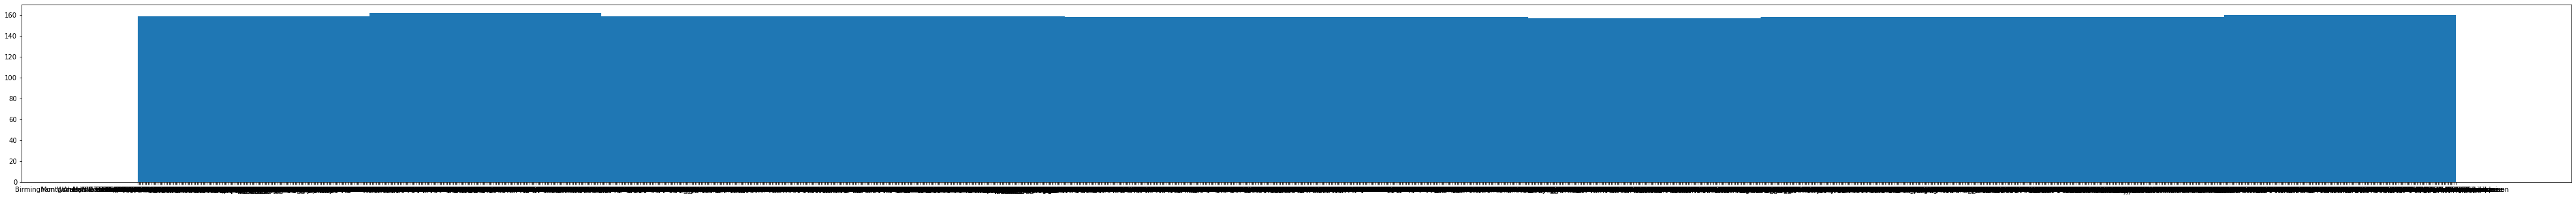

facility_type :


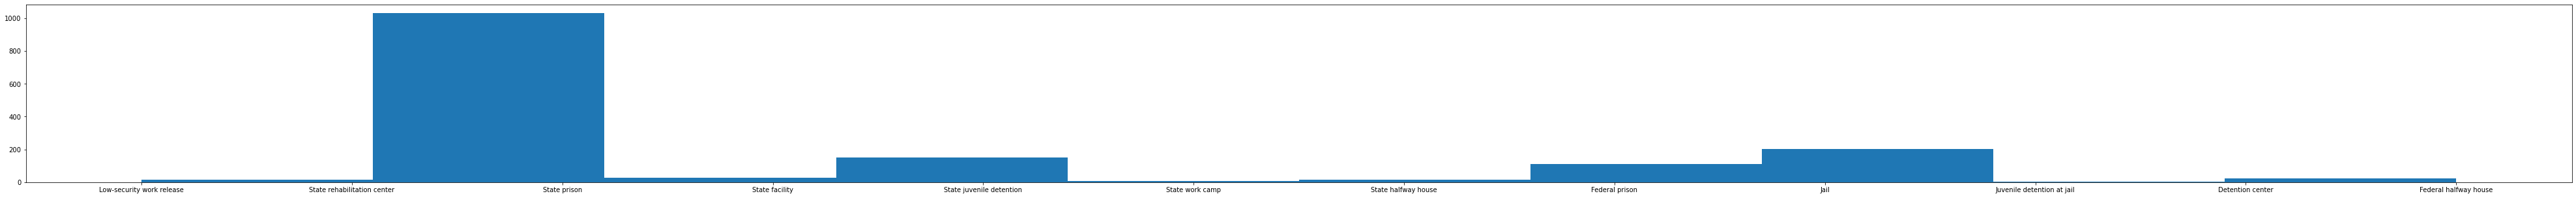

facility_city :


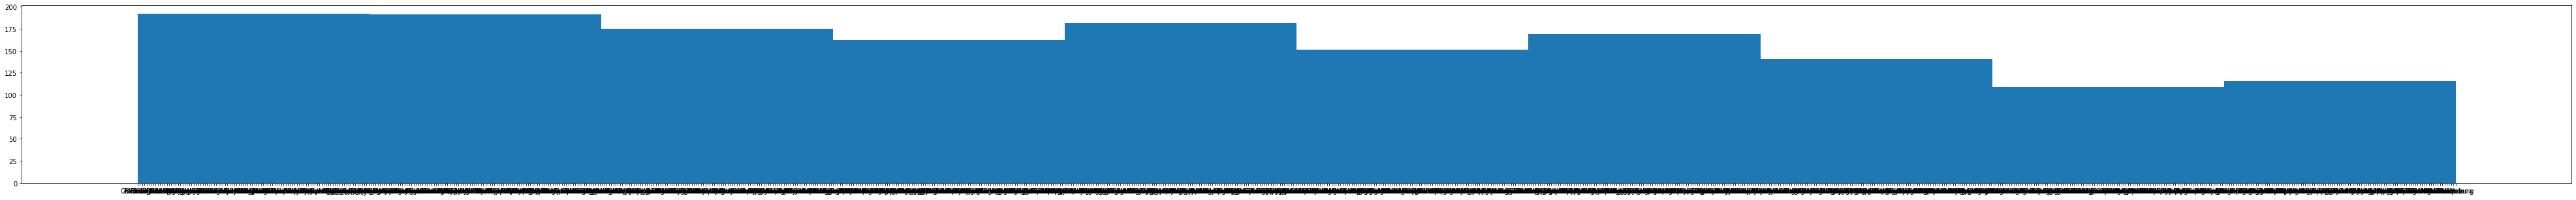

facility_county :


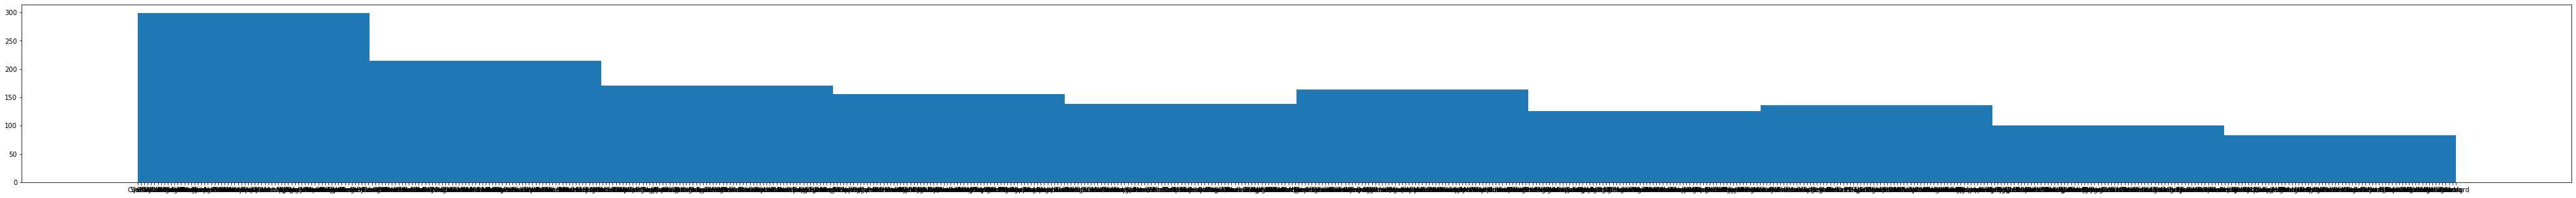

facility_state :


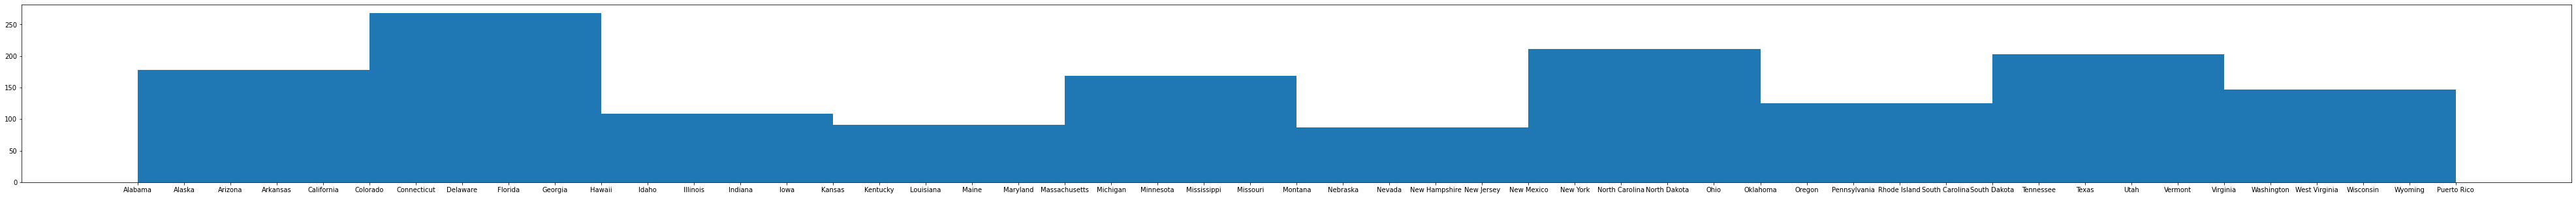

facility_lng :


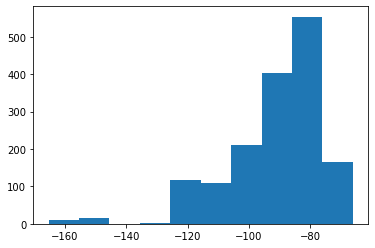

facility_lat :


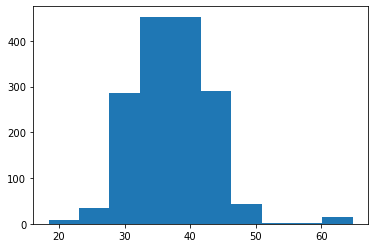

latest_inmate_population :


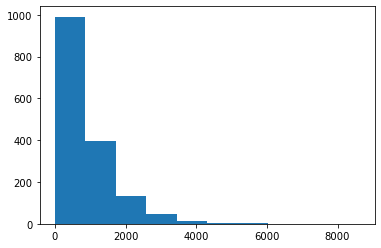

max_inmate_population_2020 :


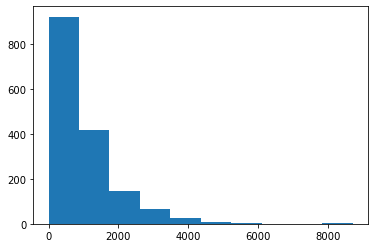

total_inmate_cases :


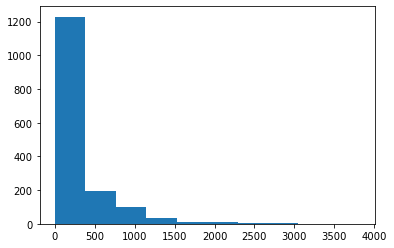

total_inmate_deaths :


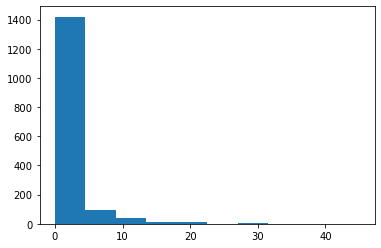

total_officer_cases :


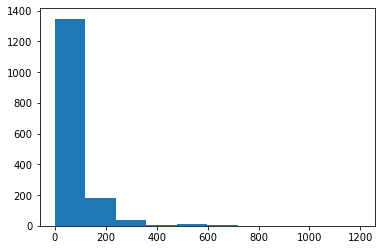

total_officer_deaths :


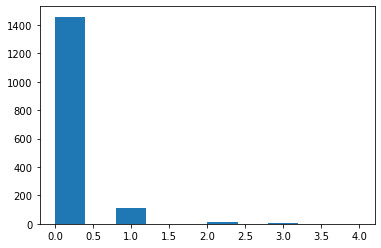

capacity_all :


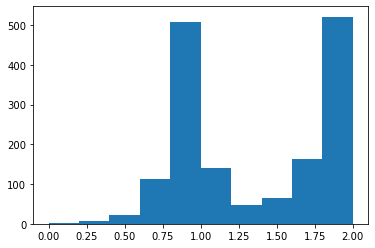

ratio_cases_inmate :


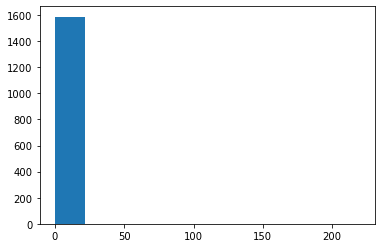

ratio_deaths_inmate :


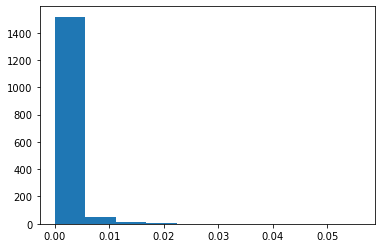

ratio_cases_officer :


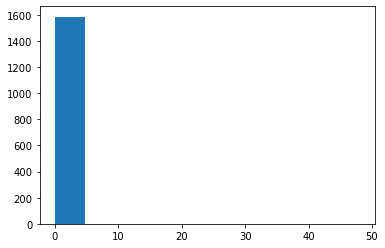

ratio_deaths_officer :


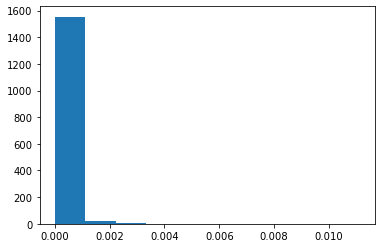

confusion_matrix for  facility_name  and  latest_inmate_population :
confusion_matrix for  facility_name  and  max_inmate_population_2020 :
confusion_matrix for  facility_name  and  total_inmate_cases :
confusion_matrix for  facility_name  and  total_inmate_deaths :
confusion_matrix for  facility_name  and  total_officer_cases :
confusion_matrix for  facility_name  and  total_officer_deaths :
confusion_matrix for  facility_name  and  capacity_all :
confusion_matrix for  facility_name  and  ratio_cases_inmate :
confusion_matrix for  facility_name  and  ratio_deaths_inmate :
confusion_matrix for  facility_name  and  ratio_cases_officer :
confusion_matrix for  facility_name  and  ratio_deaths_officer :
confusion_matrix for  facility_type  and  latest_inmate_population :
confusion_matrix for  facility_type  and  max_inmate_population_2020 :
confusion_matrix for  facility_type  and  total_inmate_cases :
confusion_matrix for  facility_type  and  total_inmate_deaths :
confusion_matrix for  fa

p values of chei test for  facility_name  and  facility_county :
p values of chei test for  facility_name  and  facility_state :
p values of chei test for  facility_name  and  facility_lng :
p values of chei test for  facility_name  and  facility_lat :
p values of chei test for  facility_name  and  latest_inmate_population :
p values of chei test for  facility_name  and  max_inmate_population_2020 :
p values of chei test for  facility_name  and  total_inmate_cases :
p values of chei test for  facility_name  and  total_inmate_deaths :
p values of chei test for  facility_name  and  total_officer_cases :
p values of chei test for  facility_name  and  total_officer_deaths :
p values of chei test for  facility_name  and  capacity_all :
p values of chei test for  facility_name  and  ratio_cases_inmate :
p values of chei test for  facility_name  and  ratio_deaths_inmate :
p values of chei test for  facility_name  and  ratio_cases_officer :
p values of chei test for  facility_name  and  ratio_

p values of chei test for  total_inmate_cases  and  ratio_deaths_inmate :
p values of chei test for  total_inmate_cases  and  ratio_cases_officer :
p values of chei test for  total_inmate_cases  and  ratio_deaths_officer :
p values of chei test for  total_inmate_deaths  and  total_officer_cases :
p values of chei test for  total_inmate_deaths  and  total_officer_deaths :
p values of chei test for  total_inmate_deaths  and  capacity_all :
p values of chei test for  total_inmate_deaths  and  ratio_cases_inmate :
p values of chei test for  total_inmate_deaths  and  ratio_deaths_inmate :
p values of chei test for  total_inmate_deaths  and  ratio_cases_officer :
p values of chei test for  total_inmate_deaths  and  ratio_deaths_officer :
p values of chei test for  total_officer_cases  and  total_officer_deaths :
p values of chei test for  total_officer_cases  and  capacity_all :
p values of chei test for  total_officer_cases  and  ratio_cases_inmate :
p values of chei test for  total_officer

,latest_inmate_population,max_inmate_population_2020,total_inmate_cases,total_inmate_deaths,total_officer_cases,total_officer_deaths,capacity_all,ratio_cases_inmate,ratio_deaths_inmate,ratio_cases_officer,ratio_deaths_officer
latest_inmate_population,1.000000,0.962916,0.688856,0.447662,0.623222,0.337945,0.406307,-0.024476,0.144602,-0.063246,0.036145
max_inmate_population_2020,0.962916,1.000000,0.677748,0.450876,0.603816,0.315424,0.314800,-0.025244,0.142553,-0.064355,0.028782
total_inmate_cases,0.688856,0.677748,1.000000,0.436363,0.569163,0.270874,0.274227,0.032935,0.203261,-0.013315,0.050676
total_inmate_deaths,0.447662,0.450876,0.436363,1.000000,0.381810,0.296423,0.186494,-0.004719,0.735788,-0.022814,0.104136
total_officer_cases,0.623222,0.603816,0.569163,0.381810,1.000000,0.410390,0.186575,0.016492,0.181591,0.019904,0.116394
total_officer_deaths,0.337945,0.315424,0.270874,0.296423,0.410390,1.000000,0.095950,-0.004234,0.184472,-0.008841,0.587422
capacity_all,0.406307,0.314800,0.274227,0.186494,0.186575,0.095950,1.000000,-0.020677,0.107919,-0.057912,0.013668
ratio_cases_inmate,-0.024476,-0.025244,0.032935,-0.004719,0.016492,-0.004234,-0.020677,1.000000,-0.001075,0.947018,-0.000288
ratio_deaths_inmate,0.144602,0.142553,0.203261,0.735788,0.181591,0.184472,0.107919,-0.001075,1.000000,-0.014095,0.209074
ratio_cases_officer,-0.063246,-0.064355,-0.013315,-0.022814,0.019904,-0.008841,-0.057912,0.947018,-0.014095,1.000000,0.001145


In [264]:

# histogram for every feature

for i in mydata.columns.values:
    if i == 'facility_name' or i == 'facility_type' or i == 'facility_city' or i == 'facility_county' or i == 'facility_state':
        plt.gcf().set_size_inches(70 ,5)
    print(i , ':')
    plt.hist(mydata[i])
    plt.show()


    
# kolmodorov smirnov test for some features

stats.kstest(mydata['facility_type'].value_counts().values, 'expon')    
stats.kstest(mydata['facility_type'].value_counts().values, 'norm')

stats.kstest(mydata['facility_city'].value_counts().values, 'expon')    
stats.kstest(mydata['facility_city'].value_counts().values, 'norm')
stats.kstest(mydata['facility_city'].value_counts().values, 'uniform')
    
stats.kstest(mydata['facility_county'].value_counts().values, 'expon')    
stats.kstest(mydata['facility_county'].value_counts().values, 'norm')
stats.kstest(mydata['facility_county'].value_counts().values, 'uniform')
    
stats.kstest(mydata['facility_state'].value_counts().values, 'expon')    
stats.kstest(mydata['facility_state'].value_counts().values, 'norm')
stats.kstest(mydata['facility_state'].value_counts().values, 'uniform')

# make confusion_matrix for every deuce variables

for i in mydata.columns.values:
    a = pd.DataFrame(mydata.columns)
    a = (a[(a == i).to_numpy()].index[0]) + 1
    b = max(7 , a)
    for j in mydata.columns[b:].values:
        if i != j:
            print('confusion_matrix for ' , i , ' and ' , j , ':')
            #pd.crosstab(index = mydata[i] , columns = mydata[j])
            

# check correlations between every deuce variables

for i in mydata.columns.values:
    a = pd.DataFrame(mydata.columns)
    a = (a[(a == i).to_numpy()].index[0]) + 1
    for j in mydata.columns[a:].values:
        print('p values of chei test for ' , i , ' and ' , j , ':')
        b = pd.crosstab(index = mydata[i] , columns = mydata[j])
        b = chi2_contingency(b , correction = False)
        #print(b[1] , '\n')

# Correlation test for numerical variables
mydata.iloc[: , 7:].corr()




In [274]:
# Takes down a variables that is not relevant to the clustering analysis

mydata = mydata.drop(columns = ['facility_name'])


#Convert numeric variables to categorical variables

ohe = OneHotEncoder(sparse=False)

a = ['facility_type' , 'facility_city' , 'facility_county' , 'facility_state']

b = ohe.fit_transform(mydata[a])

c = pd.DataFrame(b , columns = [j for i in range(4) for j in ohe.categories_[i]])

mydata = pd.concat([mydata , c] , axis = 1 , ignore_index = False)

mydata = mydata.drop(columns = a)



# normalization

scaler = MinMaxScaler()
scaler.fit(mydata)
scaler.transform(mydata)

mydata = pd.DataFrame(scaler.transform(mydata),columns = mydata.columns)

mydata

,facility_lng,facility_lat,latest_inmate_population,max_inmate_population_2020,total_inmate_cases,total_inmate_deaths,total_officer_cases,total_officer_deaths,capacity_all,ratio_cases_inmate,...,South Dakota,Tennessee,Texas,Utah,Vermont,Virginia,Washington,West Virginia,Wisconsin,Wyoming
0,0.799597,0.312500,0.021706,0.013407,0.020189,0.000000,0.014214,0.00,0.445,0.001663,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.793555,0.316810,0.031457,0.020365,0.002884,0.022222,0.001672,0.00,0.425,0.000157,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.788520,0.312500,0.200116,0.117084,0.042999,0.066667,0.051003,0.00,0.940,0.000407,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.791541,0.325431,0.022171,0.012194,0.004457,0.000000,0.023411,0.00,0.500,0.000403,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.803625,0.295259,0.171329,0.101315,0.042475,0.111111,0.066890,0.25,0.930,0.000465,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1584,0.801611,0.549569,0.187232,0.102975,0.032774,0.044444,0.000000,0.00,1.000,0.000353,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1585,0.891239,0.387931,0.000580,0.080056,0.017829,0.022222,0.000000,0.00,0.000,0.000247,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1586,0.624371,0.280172,0.116541,0.083248,0.012061,0.022222,0.000000,0.00,0.385,0.000161,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1587,0.643505,0.297414,0.191642,0.115807,0.008915,0.022222,0.000000,0.00,0.455,0.000085,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [275]:
# PCA

In [276]:
reduction_pca = PCA(n_components=2)
reduced_features = reduction_pca.fit_transform(mydata)

In [277]:
# Elbow method to determine the optimal number of clusters:

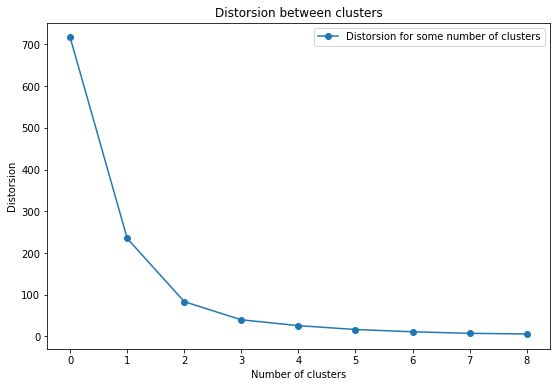

In [278]:
# במקום שנבחר מספר קבוצות שרירותי, נבחר את מספר הקבוצות המיטבי ע"פ שיטת המרפק
cluster_distorsion = []
for i in range(1, 10):
    test_sklearn = KMeans(n_clusters=i)
    test_sklearn.fit(reduced_features)
    cluster_distorsion.append(test_sklearn.inertia_)
plt.figure(figsize=(9, 6))
plt.plot(cluster_distorsion, marker='o', label='Distorsion for some number of clusters')
plt.title("Distorsion between clusters")
plt.xlabel('Number of clusters')
plt.ylabel("Distorsion")
plt.legend()
plt.show()

In [279]:
# 3 clusters it is.

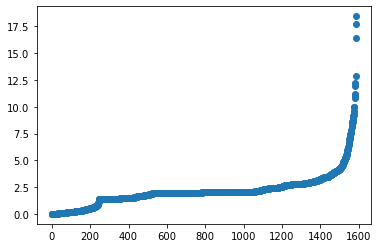

In [280]:
# We will try to evaluate some classes of the second algorithm


# reate model
modelAgglomerative = AgglomerativeClustering(n_clusters = None , linkage = 'ward' , distance_threshold = 0.005 , compute_full_tree = True , compute_distances = True)

#fit the data to model
cluster_predict = modelAgglomerative.fit_predict(mydata)

#The difference in imagination deviation in each cluster addition
plt.scatter(range(model2.distances_.shape[0]) , model2.distances_)
plt.show()


In [281]:
#The data seem to be divided into 5-6 groups with similar similarities

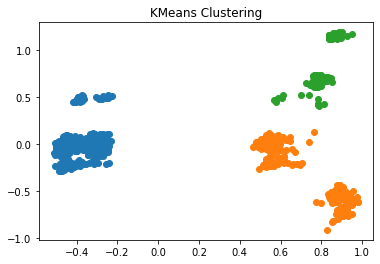

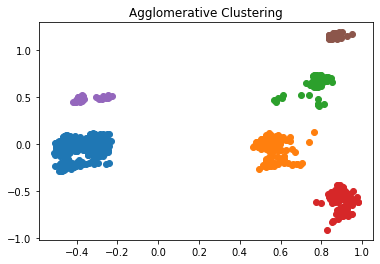

In [282]:
for i in range(2):
    X = reduced_features.copy()
    clustering_algorithms = ["KMeans", "Agglomerative"]
    # define the model
    if   i==0:
        model = KMeans(n_clusters=3)
    #elif i==1:
    else:
        model = AgglomerativeClustering(n_clusters=6)
    
    # fit model and predict clusters
    yhat = model.fit_predict(X)
    
    # save the classes into the original dataset
    data_before_encoding[clustering_algorithms[i]] = yhat
    
    # retrieve unique clusters
    clusters = unique(yhat)
    # create scatter plot for samples from each cluster
    for cluster in clusters:
        # get row indexes for samples with this cluster
        row_ix = where(yhat == cluster)
        # create scatter of these samples
        pyplot.scatter(X[row_ix, 0], X[row_ix, 1])
        # create title
        pyplot.title(clustering_algorithms[i]+" Clustering")
    # show the plot
    pyplot.show()

In [283]:
data_before_encoding

,nyt_id,facility_name,facility_type,facility_city,facility_county,facility_county_fips,facility_state,facility_lng,facility_lat,latest_inmate_population,...,capacity_nan,lng_round,lat_round,capacity_all,ratio_cases_inmate,ratio_deaths_inmate,ratio_cases_officer,ratio_deaths_officer,KMeans,Agglomerative
0,F3EFE858,Alex City Work Release prison,Low-security work release,Alex City,Coosa,1037,Alabama,-86.0,32.9,188.0,...,0.89,-85,35,0.89,0.364929,0.000000,0.080569,0.00000,1,1
1,5B910220,Alabama Therapeutic Education Facility prison,State rehabilitation center,Columbiana,Shelby,1117,Alabama,-86.6,33.1,272.0,...,0.85,-85,35,0.85,0.034375,0.003125,0.006250,0.00000,1,1
2,02FB1675,Bibb Correctional Facility,State prison,Brent,Bibb,1007,Alabama,-87.1,32.9,1725.0,...,0.94,-85,35,1.88,0.089373,0.001635,0.033243,0.00000,0,0
3,6378F6C4,Birmingham Women's Community Based Facility an...,State prison,Birmingham,Jefferson,1073,Alabama,-86.8,33.5,192.0,...,1.00,-85,35,1.00,0.088542,0.000000,0.145833,0.00000,0,0
4,EAABF900,Bullock Correctional Facility,State prison,Bessemer,Bullock,1011,Alabama,-85.6,32.1,1477.0,...,0.93,-85,30,1.86,0.102015,0.003149,0.050378,0.00063,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1584,15289545,North Lake federal prison,Federal prison,Baldwin,Lake,26085,Michigan,-85.8,43.9,1614.0,...,1.00,-85,45,2.00,0.077447,0.001239,0.000000,0.00000,1,1
1585,1558C2BF,Rivers federal prison,Federal prison,Winton,Hertford,37091,North Carolina,-76.9,36.4,6.0,...,0.00,-75,35,0.00,0.054183,0.000797,0.000000,0.00000,1,1
1586,C9CF62B9,Reeves County federal prison,Federal prison,Pecos,Reeves,48389,Texas,-103.4,31.4,1005.0,...,0.77,-105,30,0.77,0.035249,0.000766,0.000000,0.00000,1,1
1587,364869B9,Flightline federal prison,Federal prison,Big Spring,Howard,48227,Texas,-101.5,32.2,1652.0,...,0.91,-100,30,0.91,0.018733,0.000551,0.000000,0.00000,1,1


In [284]:
data_before_encoding.corr()

,facility_county_fips,facility_lng,facility_lat,latest_inmate_population,max_inmate_population_2020,total_inmate_cases,total_inmate_deaths,total_officer_cases,total_officer_deaths,capacity,capacity_nan,lng_round,lat_round,capacity_all,ratio_cases_inmate,ratio_deaths_inmate,ratio_cases_officer,ratio_deaths_officer,KMeans,Agglomerative
facility_county_fips,1.000000,0.160408,0.125104,-0.037583,-0.040743,-0.085311,-0.051514,-0.077986,0.005344,0.026959,0.026959,0.150761,0.112178,0.034419,0.027544,0.003466,0.004904,0.046707,-0.068153,-0.205812
facility_lng,0.160408,1.000000,-0.143428,-0.110308,-0.113193,-0.197361,-0.002568,-0.160850,-0.082358,0.037912,0.037912,0.995469,-0.143392,0.029292,-0.017390,0.043009,0.001294,-0.007532,0.043312,0.057478
facility_lat,0.125104,-0.143428,1.000000,-0.123607,-0.114759,0.020803,-0.068477,-0.016712,-0.092686,-0.052045,-0.052045,-0.152961,0.969672,-0.011986,-0.039753,-0.059536,-0.048614,-0.044795,-0.156095,-0.337985
latest_inmate_population,-0.037583,-0.110308,-0.123607,1.000000,0.967292,0.688896,0.447722,0.623219,0.337990,0.086508,0.086508,-0.108035,-0.119606,0.407785,-0.024842,0.125208,-0.062856,0.034778,-0.274818,-0.155816
max_inmate_population_2020,-0.040743,-0.113193,-0.114759,0.967292,1.000000,0.687080,0.436229,0.631483,0.331632,-0.068894,-0.068894,-0.111403,-0.112844,0.316542,-0.024524,0.116701,-0.061905,0.028775,-0.246055,-0.149330
total_inmate_cases,-0.085311,-0.197361,0.020803,0.688896,0.687080,1.000000,0.436445,0.569149,0.270938,-0.014750,-0.014750,-0.198547,0.024466,0.270618,0.032757,0.179163,-0.013090,0.048102,-0.189636,-0.152462
total_inmate_deaths,-0.051514,-0.002568,-0.068477,0.447722,0.436229,0.436445,1.000000,0.381821,0.296472,-0.000918,-0.000918,-0.004136,-0.070013,0.194473,-0.004648,0.689783,-0.022189,0.102311,-0.164567,-0.132523
total_officer_cases,-0.077986,-0.160850,-0.016712,0.623219,0.631483,0.569149,0.381821,1.000000,0.410401,0.031777,0.031777,-0.162606,-0.012022,0.186420,0.016264,0.164380,0.020020,0.114867,-0.202885,-0.094853
total_officer_deaths,0.005344,-0.082358,-0.092686,0.337990,0.331632,0.270938,0.296472,0.410401,1.000000,0.023798,0.023798,-0.079173,-0.085135,0.092609,-0.004560,0.161444,-0.008887,0.581585,-0.097361,-0.060830
capacity,0.026959,0.037912,-0.052045,0.086508,-0.068894,-0.014750,-0.000918,0.031777,0.023798,1.000000,1.000000,0.038845,-0.048307,0.391184,0.026888,0.036246,0.042203,0.026952,-0.024085,0.054304


In [285]:
# שמירה עבור בדיקה של רסקו
#data_before_encoding.to_csv('with_clusteing_lables.csv')

In [286]:
# מכאן צריך להמשיך ולסיים בניתוחים

In [287]:
def myround(x, base = 10):
    return base * round(float(x) / base)

def myround_freq(x, base = 5):
    return base * round(float(x * 100) / base) / 100

data = data_before_encoding.copy()
#data = pd.read_csv("with_clusteing_lables.csv",encoding='latin-1')

data['lng_round']  = data.apply(lambda x: myround(x.facility_lng                          ), axis = 1)
data['lat_round']  = data.apply(lambda x: myround(x.facility_lat                          ), axis = 1)
data['max_round']  = data.apply(lambda x: myround(x.max_inmate_population_2020 , base = 50), axis = 1)
data['late_round'] = data.apply(lambda x: myround(x.latest_inmate_population   , base = 50), axis = 1)

data['area']      = data['lng_round'].astype(str) + '_' + data['lat_round'].astype(str)

#data              = data.merge(facilities, how = 'inner')

data_original     = data.dropna(subset=['capacity'    ]).reset_index()
data_imputed      = data.dropna(subset=['capacity_nan']).reset_index()

data_imputed ['capacity_round'] = data_imputed.apply(lambda x:  myround_freq(x.capacity_nan), axis = 1)
data_original['capacity_round'] = data_original.apply(lambda x: myround_freq(x.capacity)   , axis = 1 )

#display(data_imputed.filter(items =  ['capacity_nan', 'capacity_round']))
#display(data_original.filter(items = ['capacity'   , 'capacity_round' ]))

#print(display(data_imputed.columns))

#display(data_original, data_imputed)


In [288]:
data_imputed

,index,nyt_id,facility_name,facility_type,facility_city,facility_county,facility_county_fips,facility_state,facility_lng,facility_lat,...,ratio_cases_inmate,ratio_deaths_inmate,ratio_cases_officer,ratio_deaths_officer,KMeans,Agglomerative,max_round,late_round,area,capacity_round
0,0,F3EFE858,Alex City Work Release prison,Low-security work release,Alex City,Coosa,1037,Alabama,-86.0,32.9,...,0.364929,0.000000,0.080569,0.00000,1,1,200,200,-90_30,0.90
1,1,5B910220,Alabama Therapeutic Education Facility prison,State rehabilitation center,Columbiana,Shelby,1117,Alabama,-86.6,33.1,...,0.034375,0.003125,0.006250,0.00000,1,1,300,250,-90_30,0.85
2,2,02FB1675,Bibb Correctional Facility,State prison,Brent,Bibb,1007,Alabama,-87.1,32.9,...,0.089373,0.001635,0.033243,0.00000,0,0,1850,1700,-90_30,0.95
3,3,6378F6C4,Birmingham Women's Community Based Facility an...,State prison,Birmingham,Jefferson,1073,Alabama,-86.8,33.5,...,0.088542,0.000000,0.145833,0.00000,0,0,200,200,-90_30,1.00
4,4,EAABF900,Bullock Correctional Facility,State prison,Bessemer,Bullock,1011,Alabama,-85.6,32.1,...,0.102015,0.003149,0.050378,0.00063,0,0,1600,1500,-90_30,0.95
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1584,1584,15289545,North Lake federal prison,Federal prison,Baldwin,Lake,26085,Michigan,-85.8,43.9,...,0.077447,0.001239,0.000000,0.00000,1,1,1600,1600,-90_40,1.00
1585,1585,1558C2BF,Rivers federal prison,Federal prison,Winton,Hertford,37091,North Carolina,-76.9,36.4,...,0.054183,0.000797,0.000000,0.00000,1,1,1250,0,-80_40,0.00
1586,1586,C9CF62B9,Reeves County federal prison,Federal prison,Pecos,Reeves,48389,Texas,-103.4,31.4,...,0.035249,0.000766,0.000000,0.00000,1,1,1300,1000,-100_30,0.75
1587,1587,364869B9,Flightline federal prison,Federal prison,Big Spring,Howard,48227,Texas,-101.5,32.2,...,0.018733,0.000551,0.000000,0.00000,1,1,1800,1650,-100_30,0.90


In [289]:
data_imputed  = data_imputed.filter(items =  ['latest_inmate_population', 'max_inmate_population_2020', 'total_inmate_cases', 'total_inmate_deaths', 'total_officer_cases', 'total_officer_deaths', 'ratio_cases_inmate', 'ratio_deaths_inmate', 'ratio_cases_officer', 'ratio_deaths_officer', 'lng_round', 'lat_round', 'capacity_round', 'facility_type', 'facility_state', 'area', 'KMeans', 'Agglomerative'])
data_original = data_original.filter(items =  ['latest_inmate_population', 'max_inmate_population_2020', 'total_inmate_cases', 'total_inmate_deaths', 'total_officer_cases', 'total_officer_deaths', 'ratio_cases_inmate', 'ratio_deaths_inmate', 'ratio_cases_officer', 'ratio_deaths_officer', 'lng_round', 'lat_round', 'capacity_round', 'facility_type', 'facility_state', 'area', 'KMeans', 'Agglomerative'])
data = data.filter(items =  ['latest_inmate_population', 'max_inmate_population_2020', 'total_inmate_cases', 'total_inmate_deaths', 'total_officer_cases', 'total_officer_deaths', 'ratio_cases_inmate', 'ratio_deaths_inmate', 'ratio_cases_officer', 'ratio_deaths_officer', 'lng_round', 'lat_round', 'capacity_round', 'facility_type', 'facility_state', 'area', 'KMeans', 'Agglomerative'])

In [290]:
data_imputed.dtypes

latest_inmate_population      float64
max_inmate_population_2020      int32
total_inmate_cases              int64
total_inmate_deaths             int64
total_officer_cases             int64
total_officer_deaths          float64
ratio_cases_inmate            float64
ratio_deaths_inmate           float64
ratio_cases_officer           float64
ratio_deaths_officer          float64
lng_round                       int64
lat_round                       int64
capacity_round                float64
facility_type                  object
facility_state                 object
area                           object
KMeans                          int32
Agglomerative                   int64
dtype: object

1


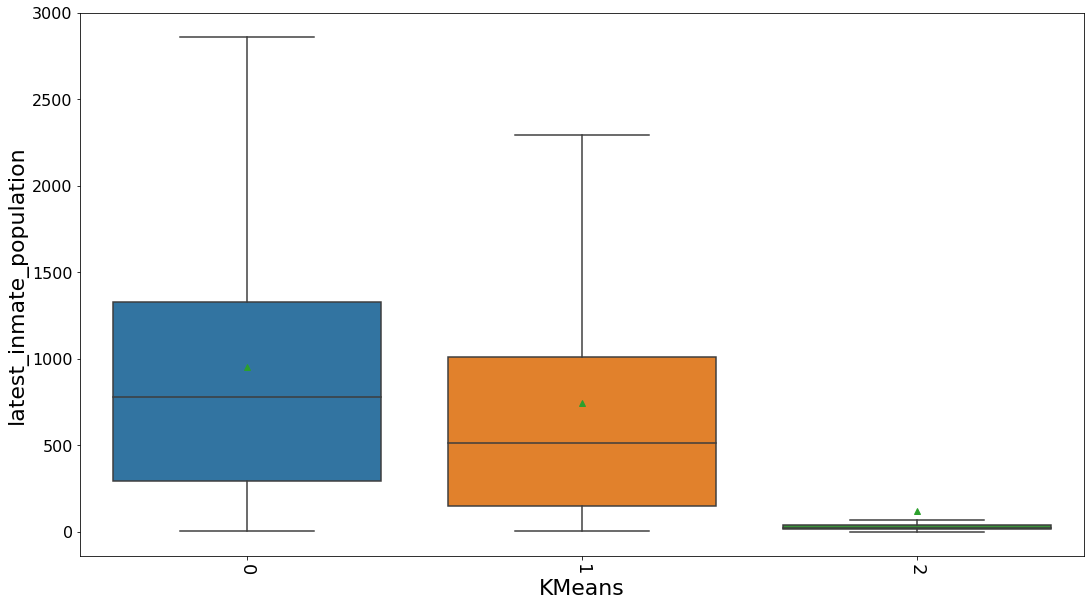

1


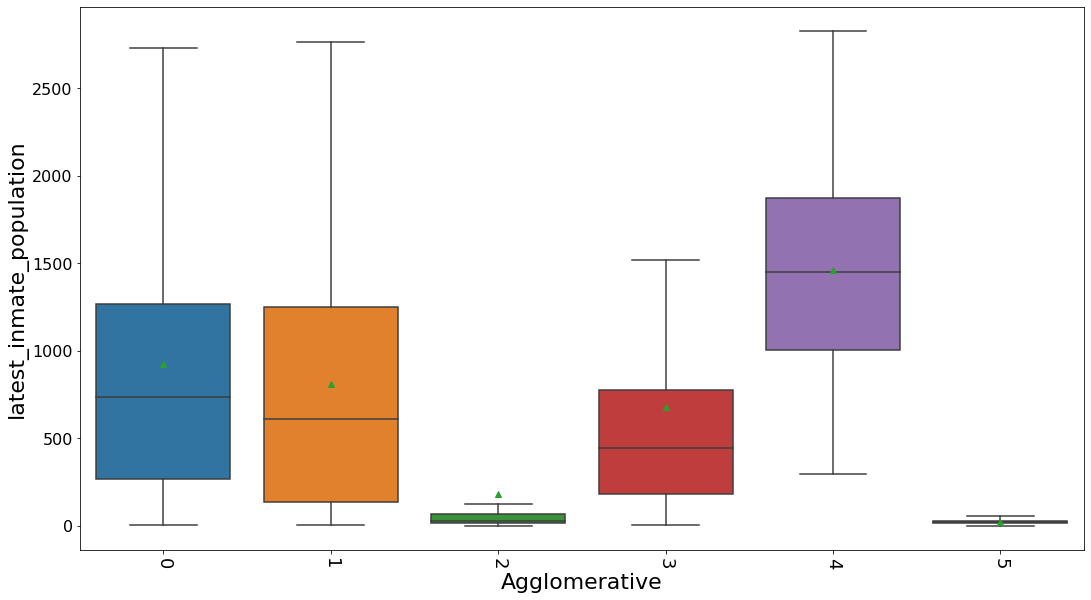

1


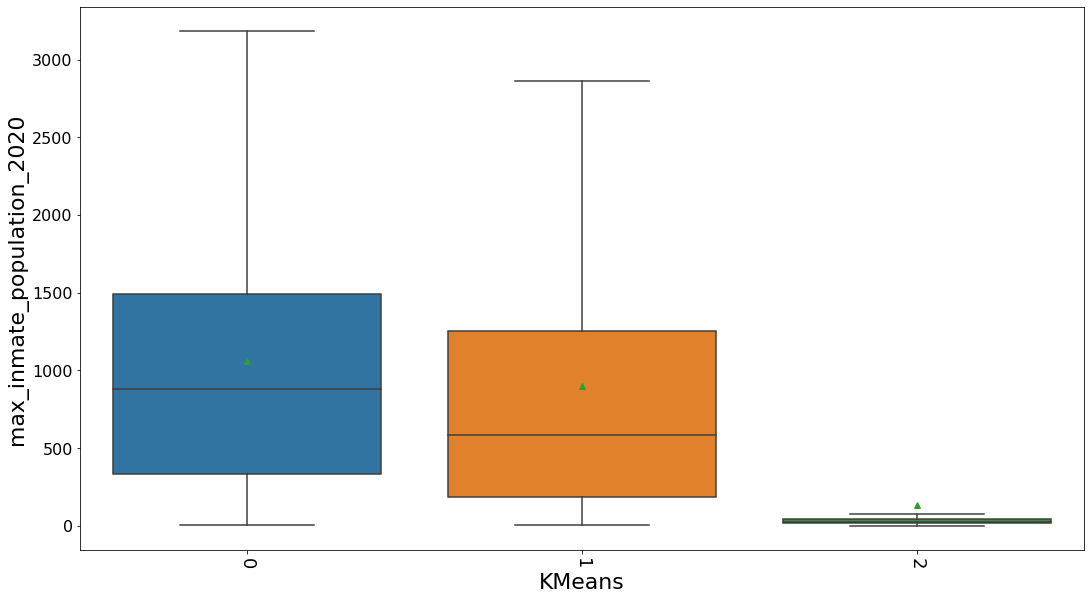

1


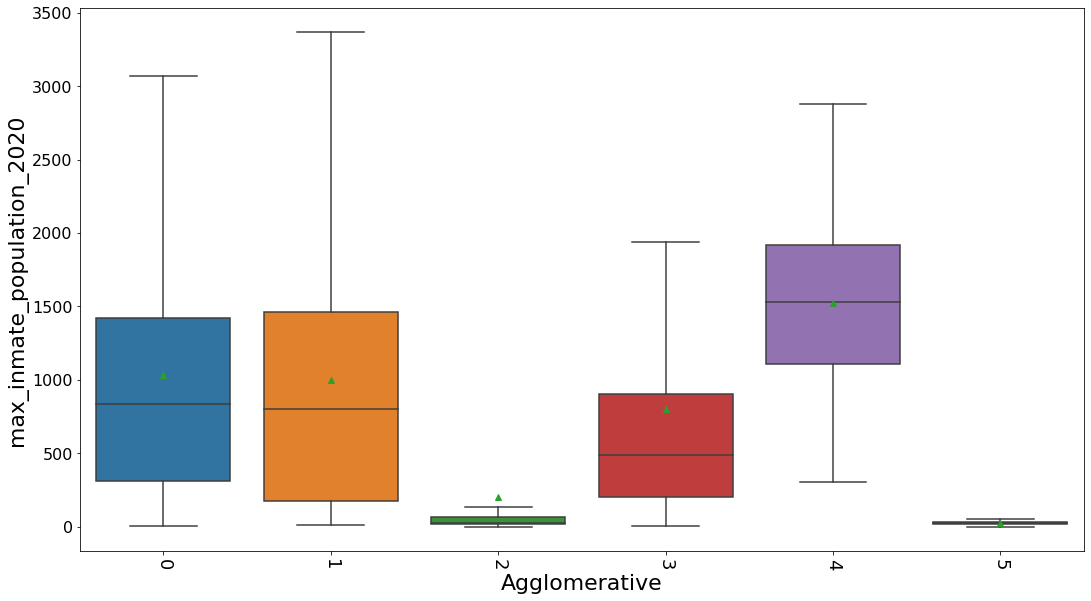

1


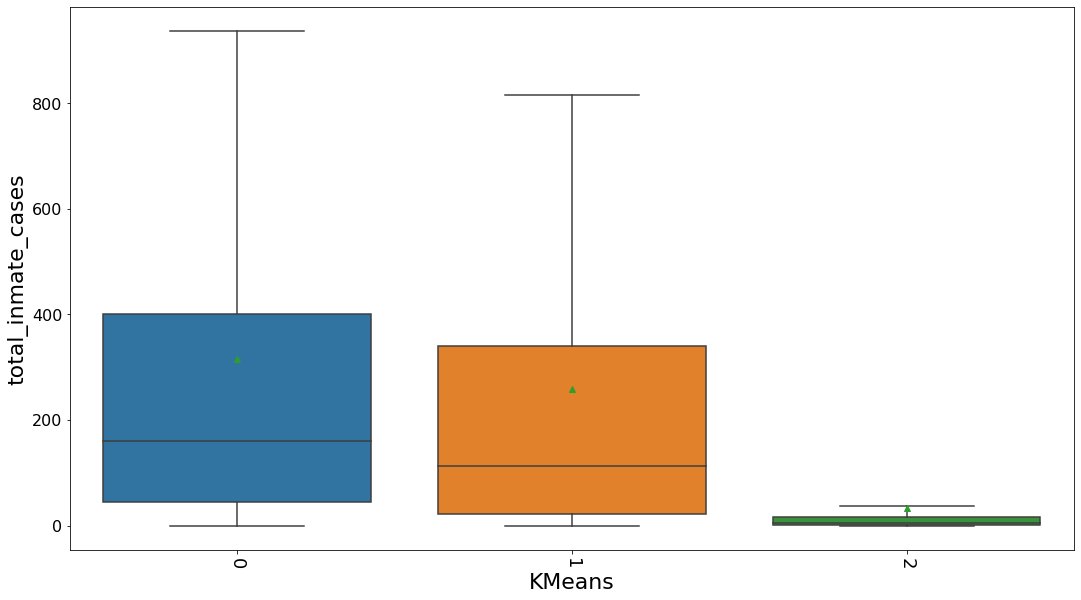

1


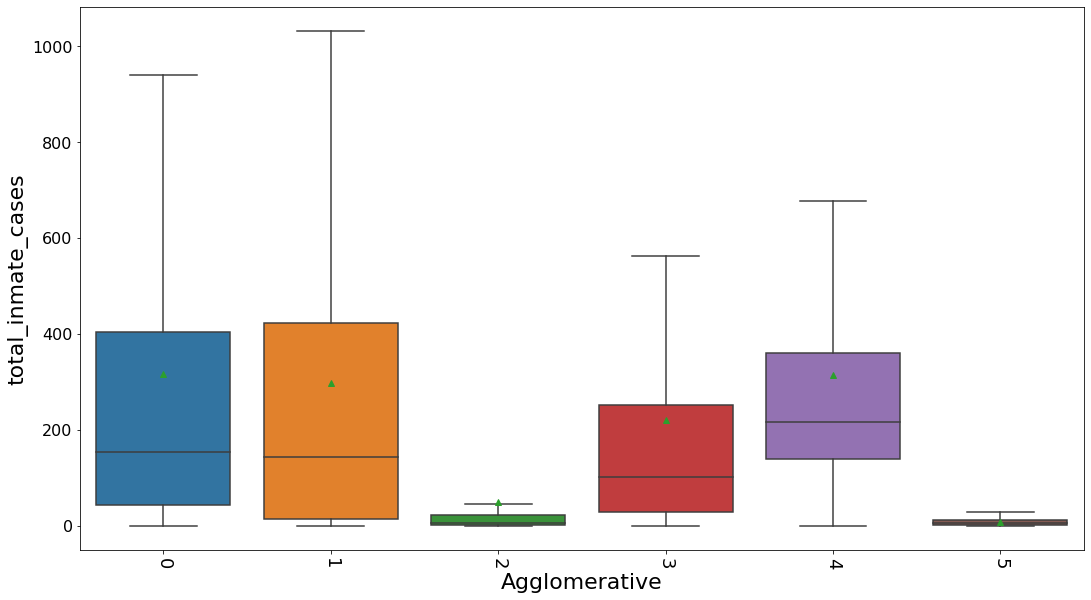

1


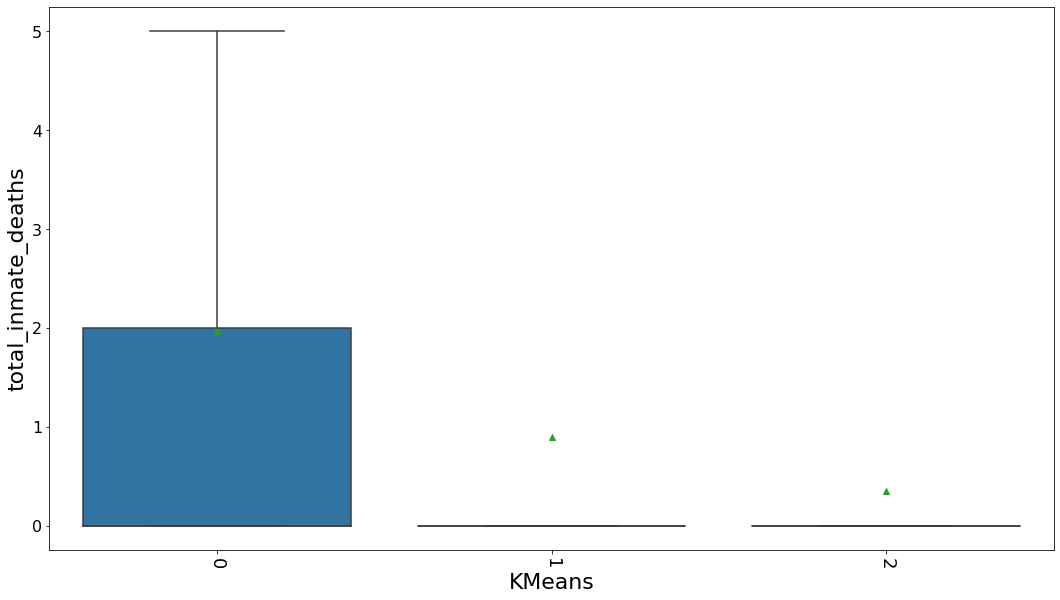

1


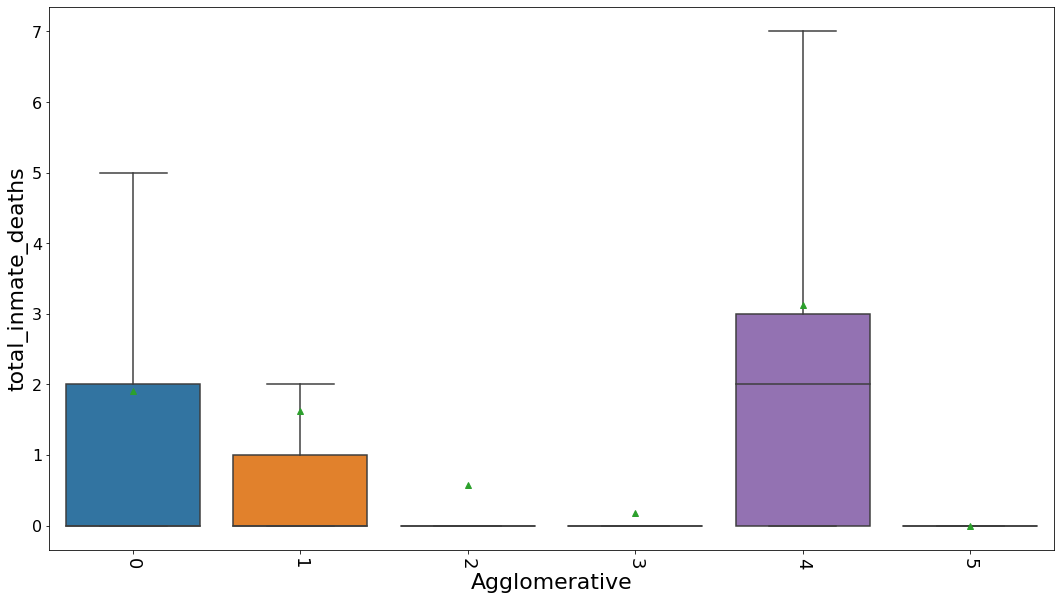

1


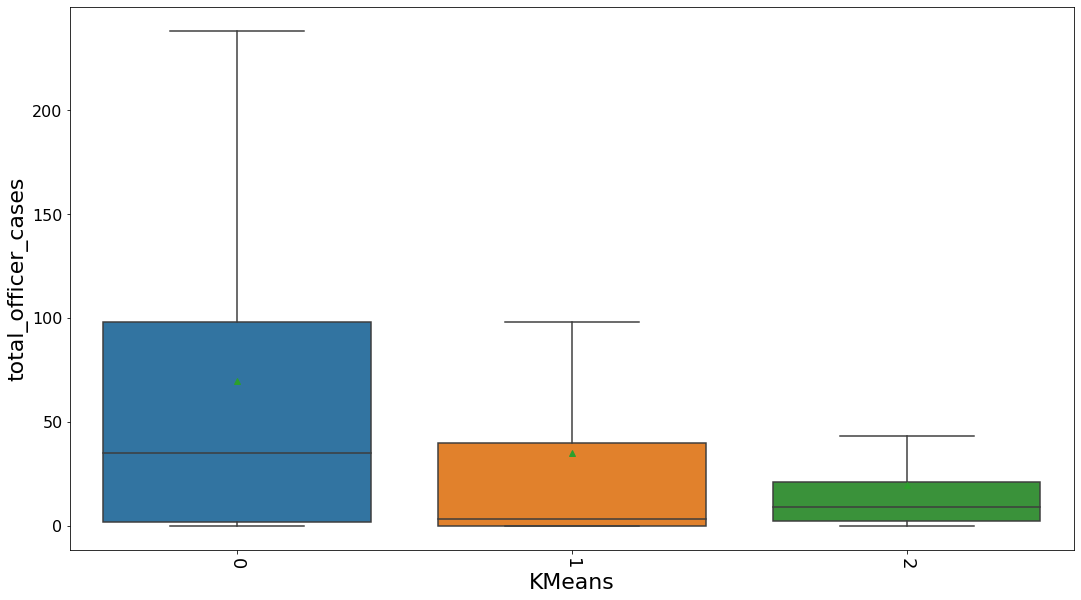

1


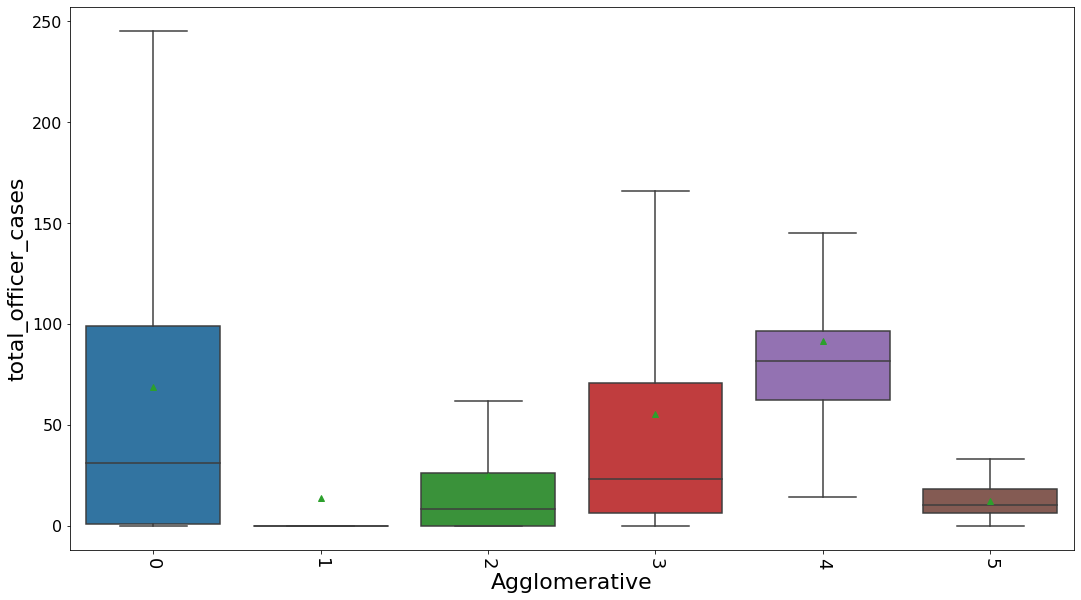

1


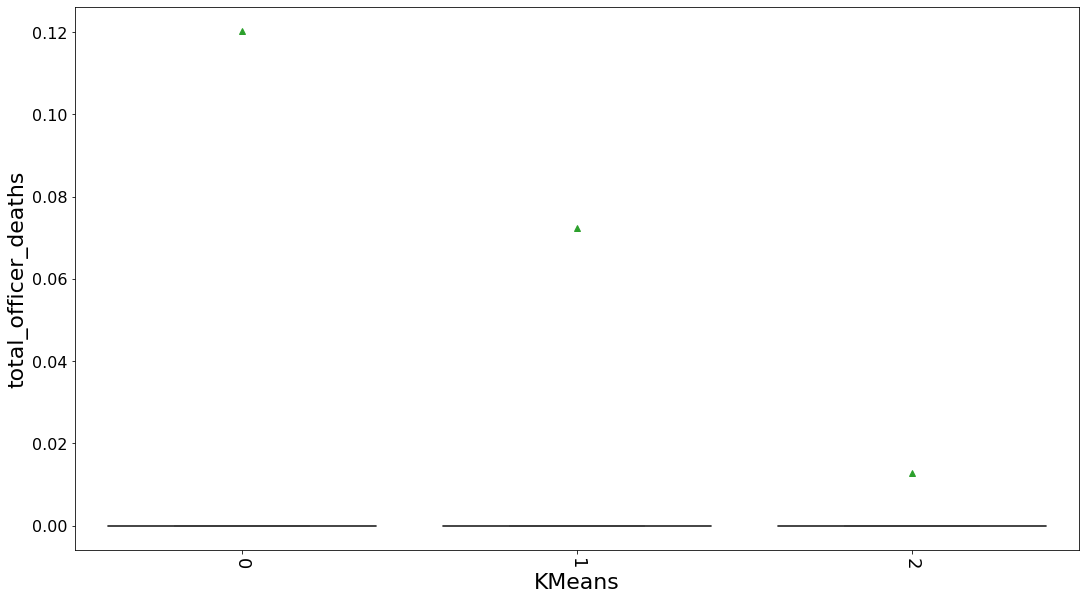

1


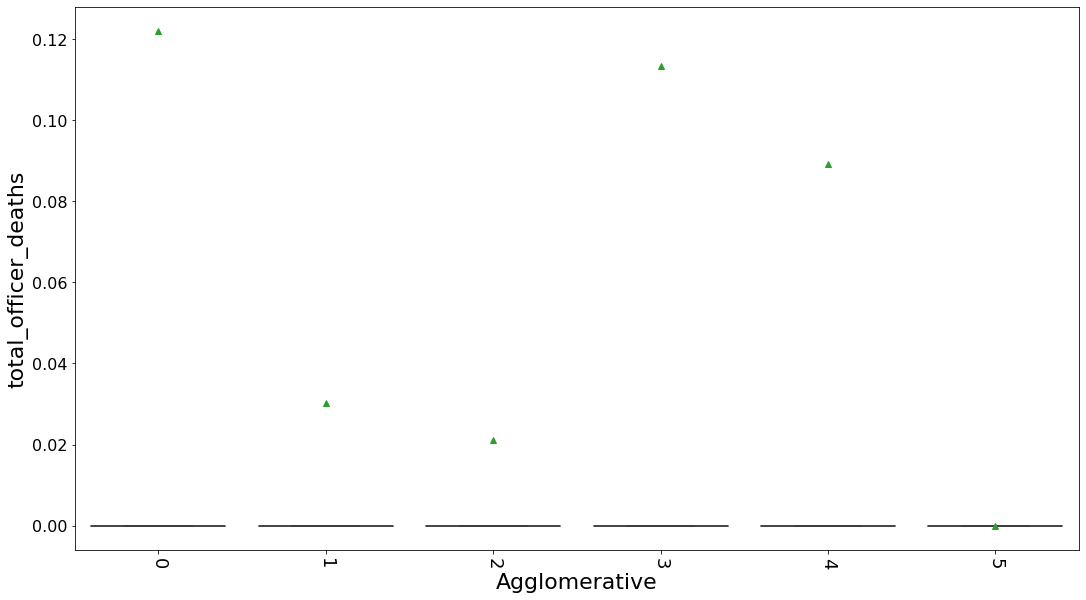

1


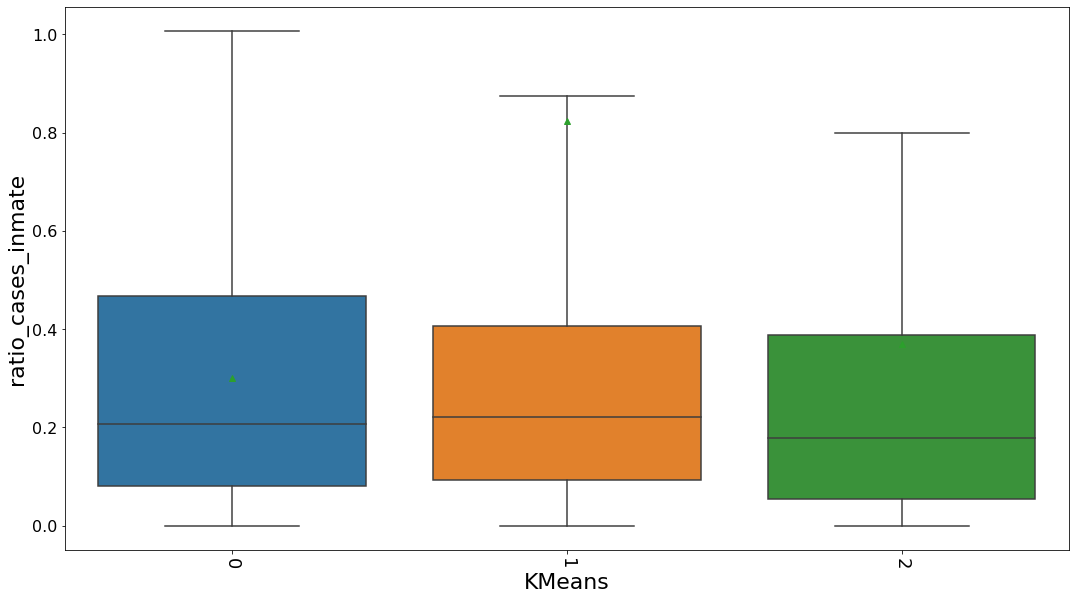

1


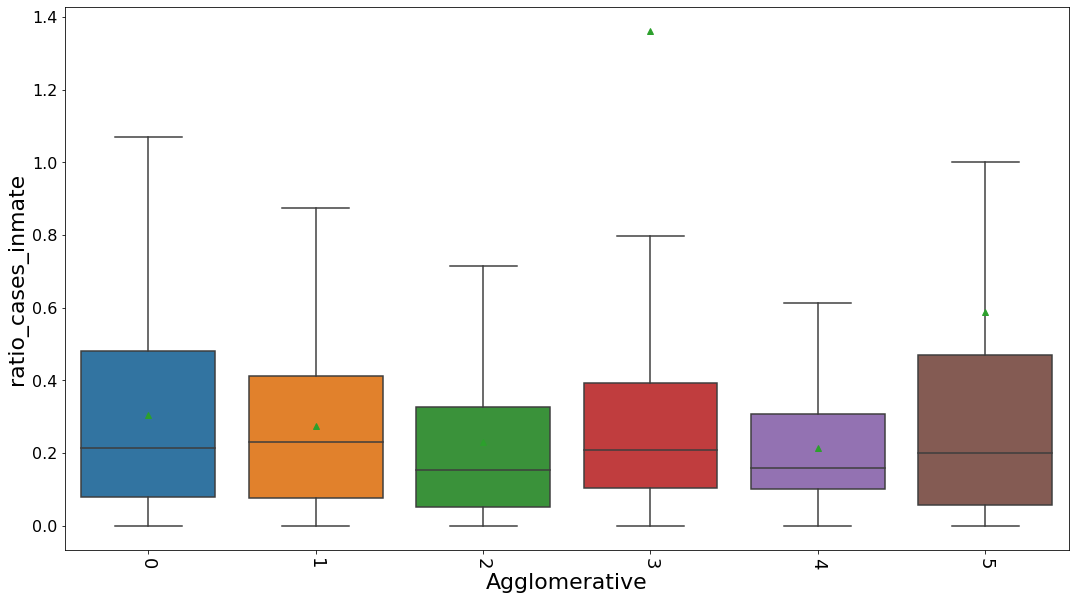

1


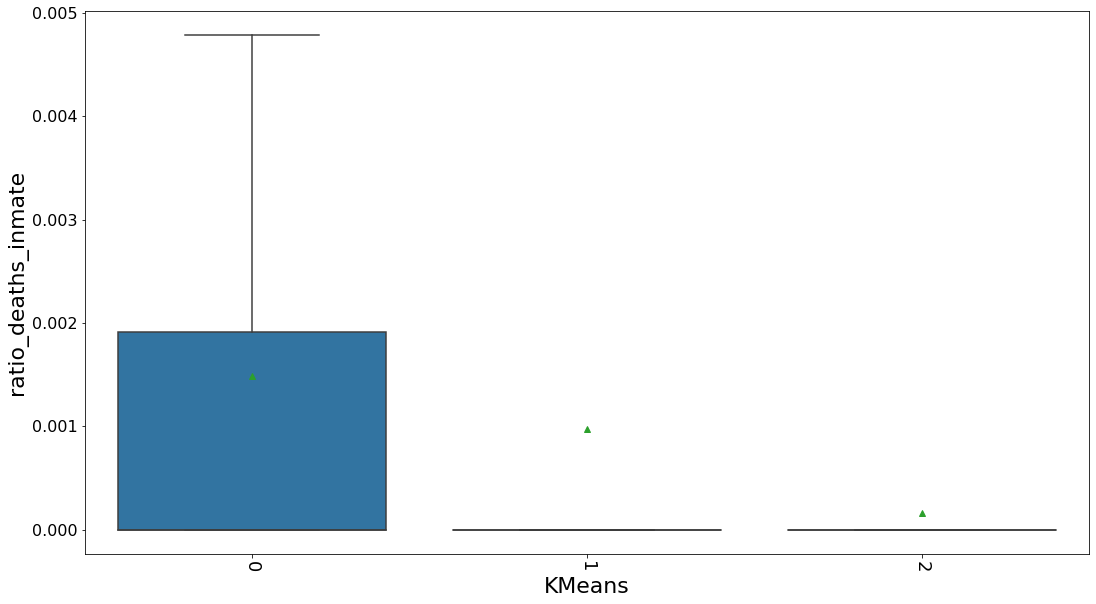

1


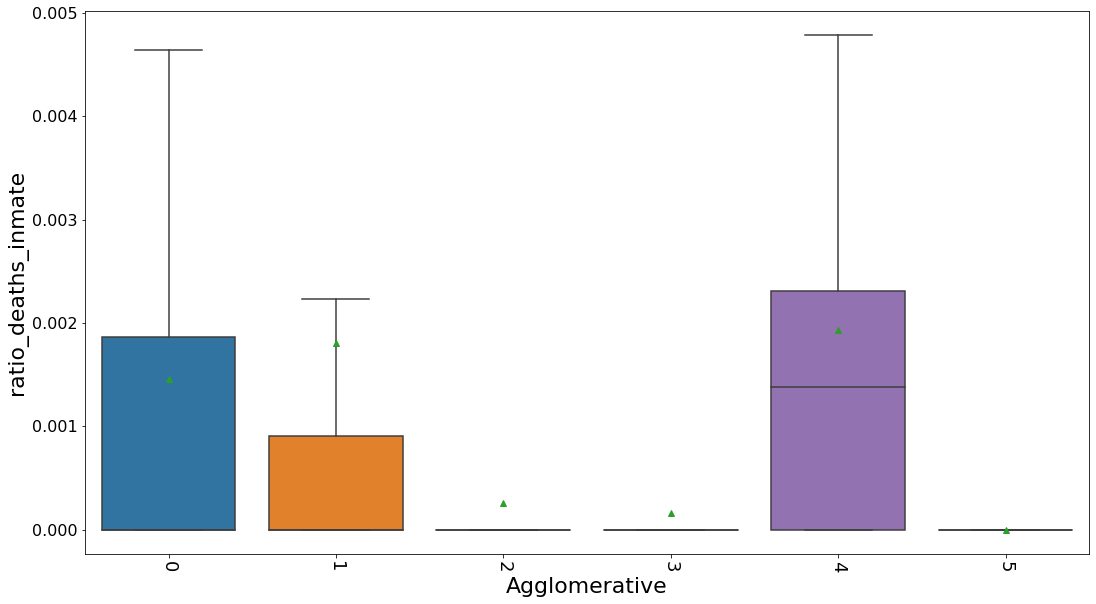

1


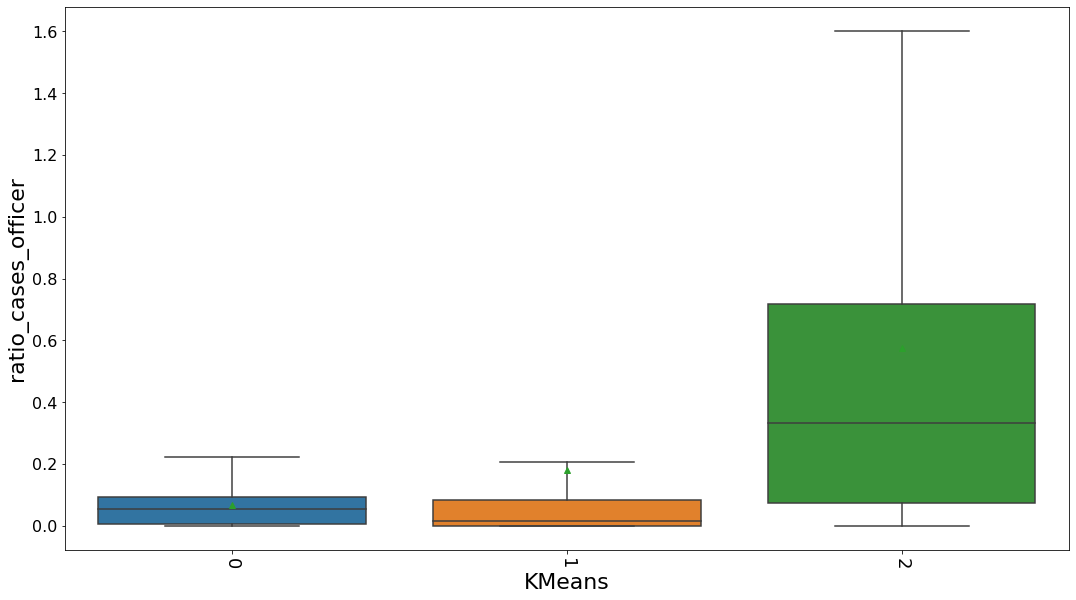

1


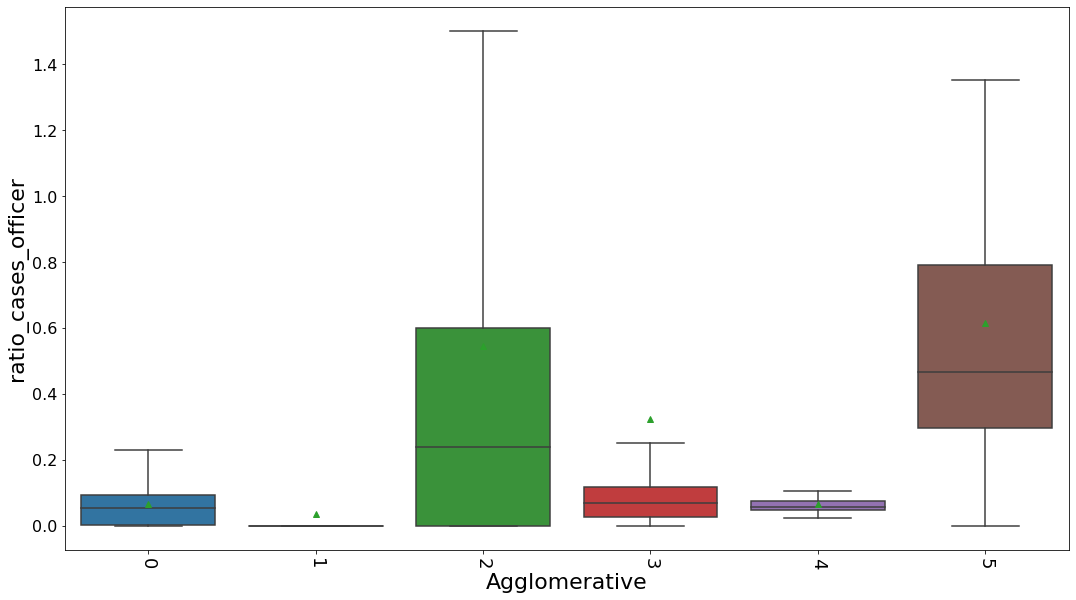

1


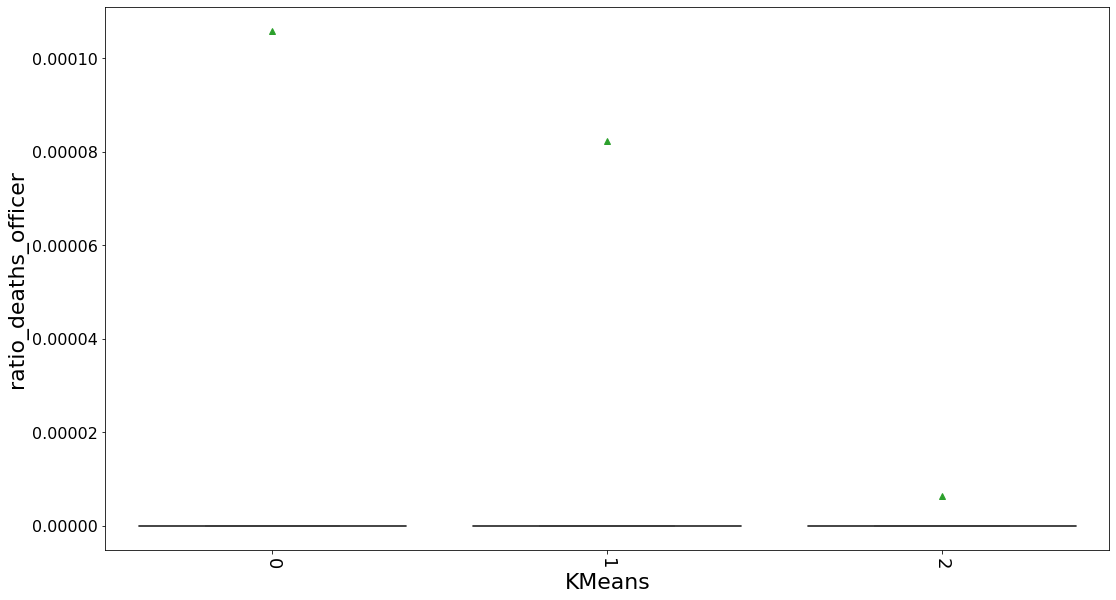

1


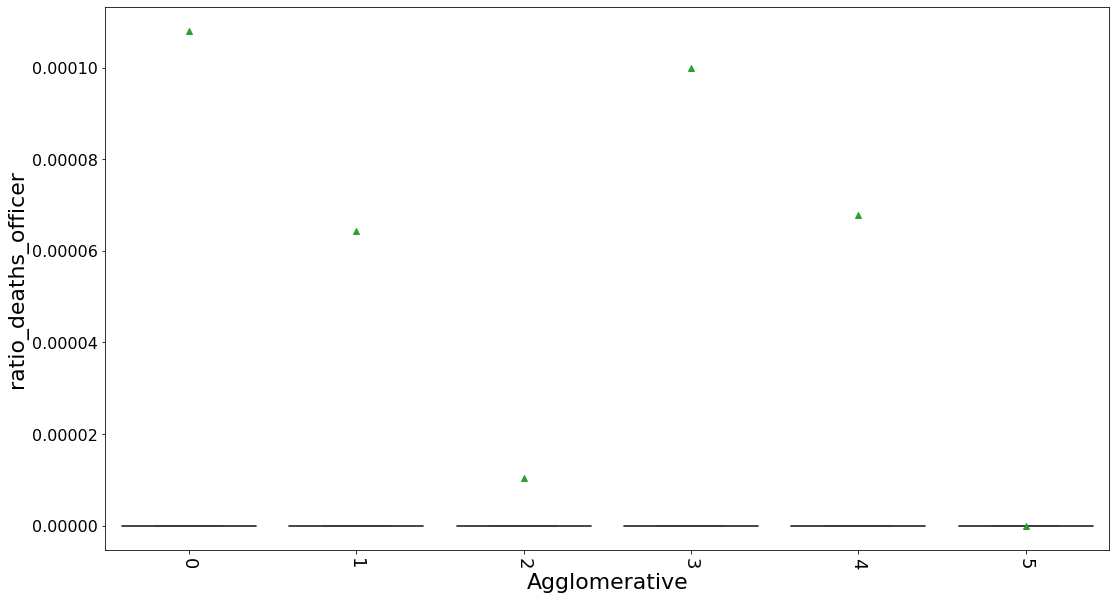

1


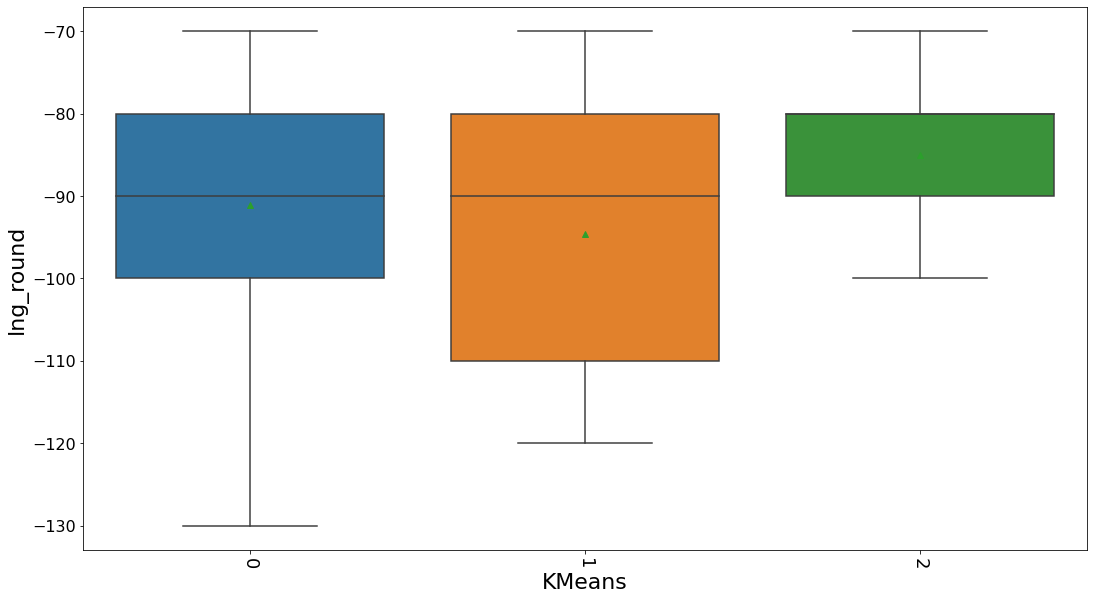

1


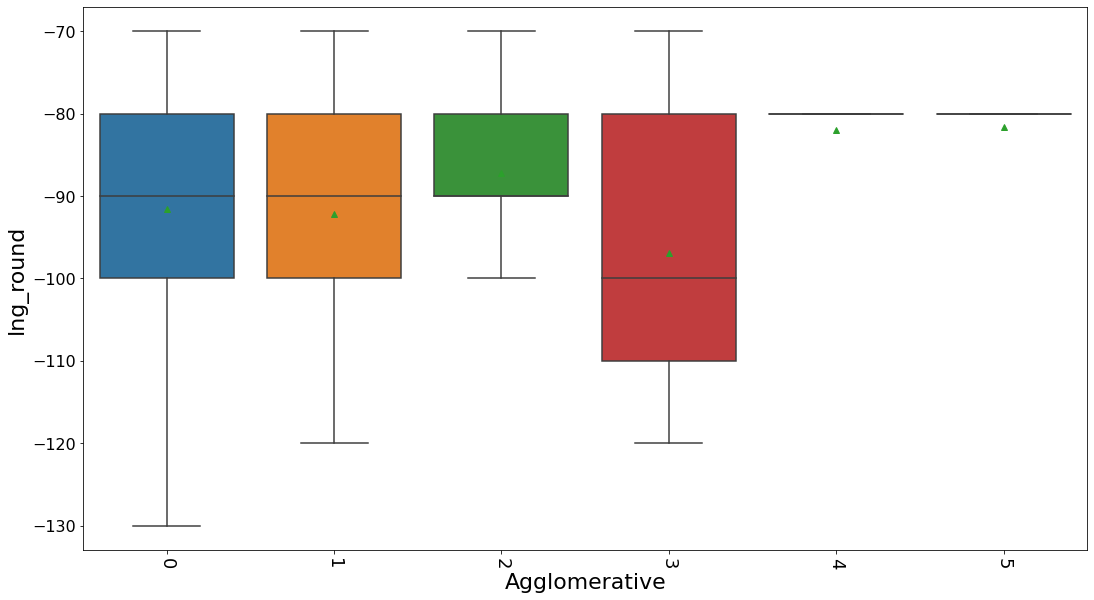

1


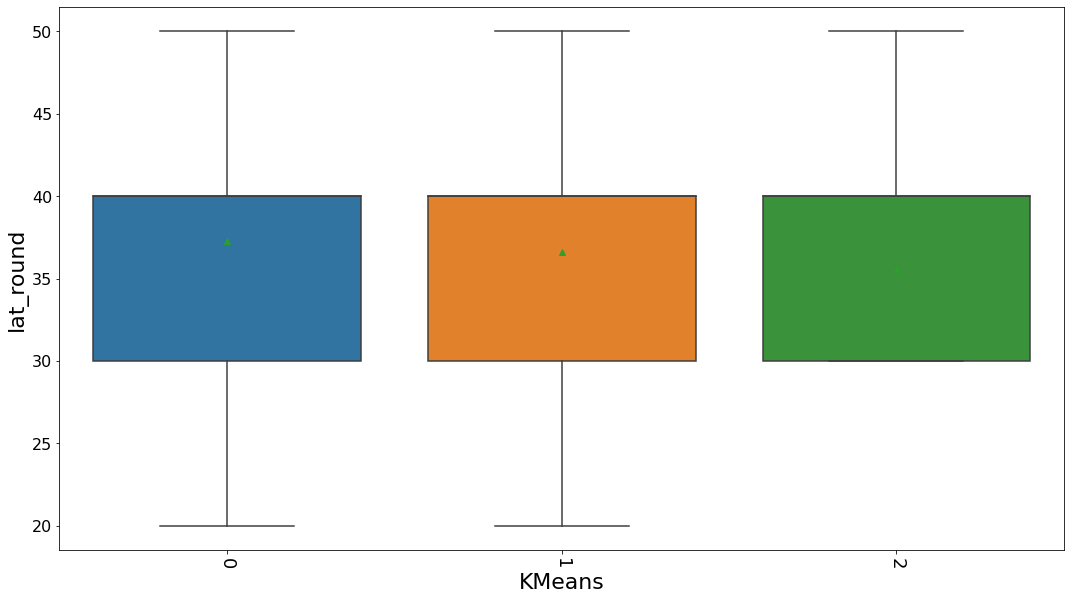

1


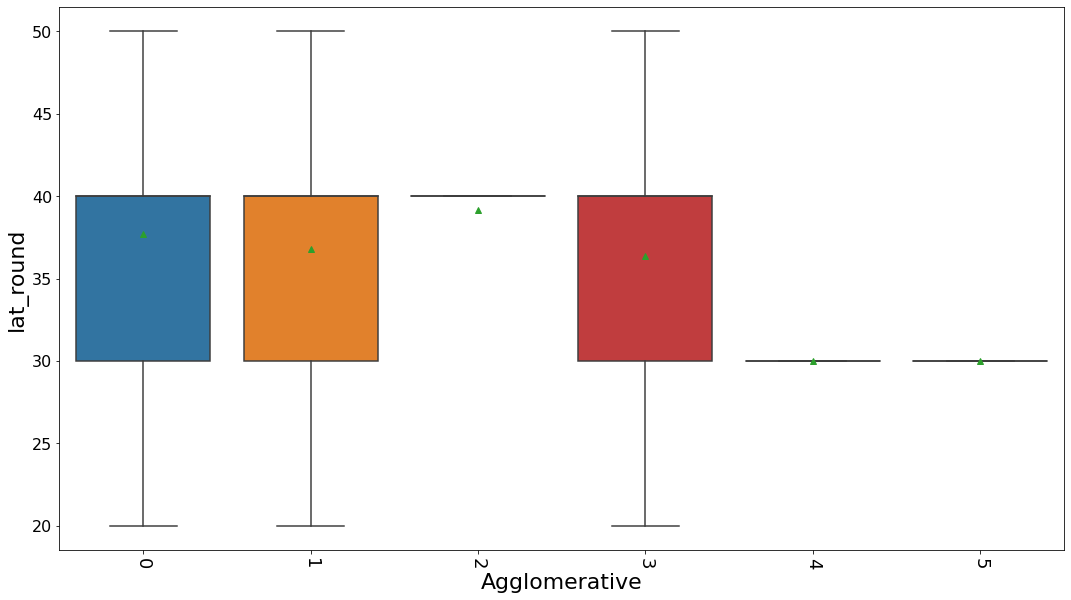

1


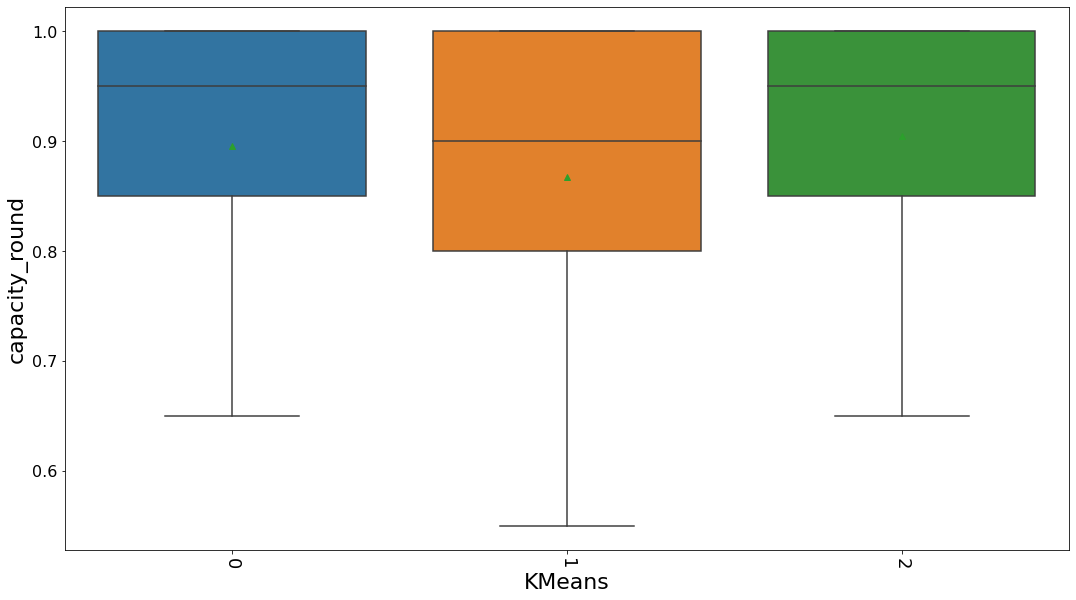

1


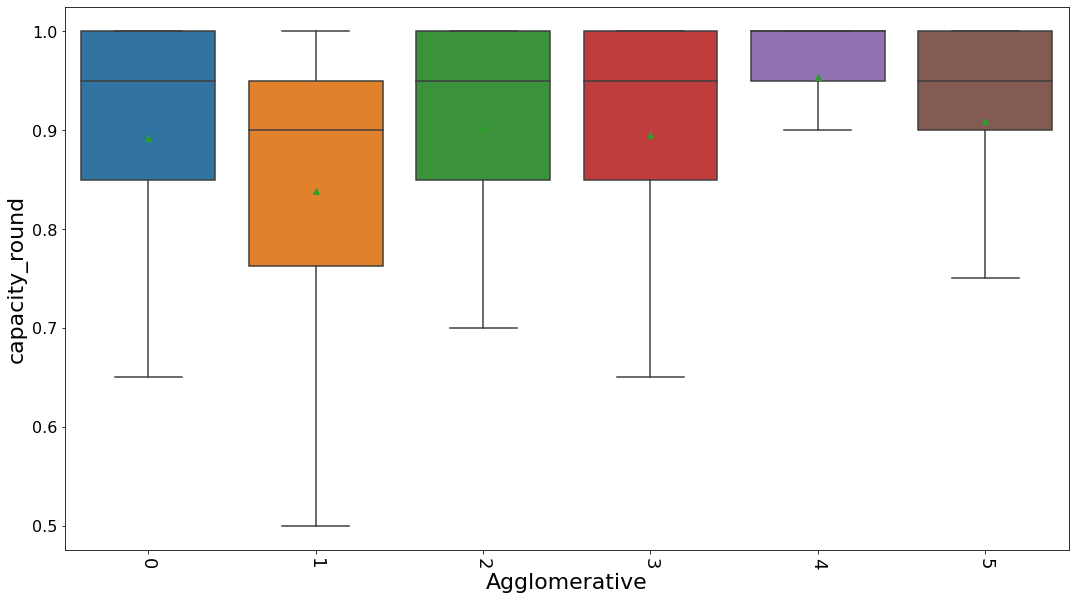

In [291]:
for a_col in data_imputed.columns[:16]:  
    for b_col in data_imputed.columns[-2:]:
        try:
            if a_col != 'facility_type' and a_col != 'facility_state' and a_col != 'area':
                print(1)
                sns.boxplot(x = b_col, y = a_col, data = data_imputed, showfliers = False, showmeans = True)
                fig = plt.gcf()
                fig.set_size_inches(18, 10)
                plt.xticks(fontsize = 18, rotation=-90)
                plt.yticks(fontsize = 16)
                plt.xlabel(b_col, fontsize = 22)
                plt.ylabel(a_col, fontsize = 22)
                plt.show()
                
            else:
                b_col
            
        except:
            print(a_col, b_col)
            sns.catplot(x = b_col, hue = a_col, kind = "count", data = data)
            fig = plt.gcf()
            fig.set_size_inches(18, 10)
            plt.xticks(fontsize = 18, rotation=-90)
            plt.yticks(fontsize = 16)
            plt.xlabel(b_col, fontsize = 22)
            plt.ylabel(a_col, fontsize = 22)
            plt.show()

In [292]:
# We bet the data to categorical.
# In retrospect we did not need it at the end so we attached the code in the appendix

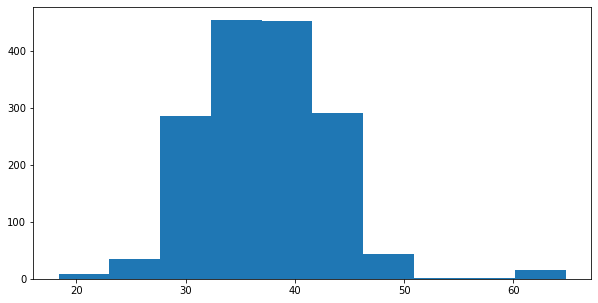

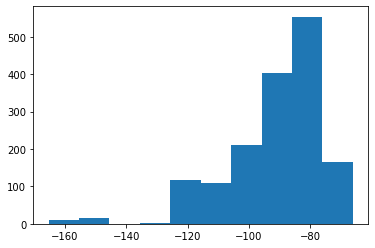

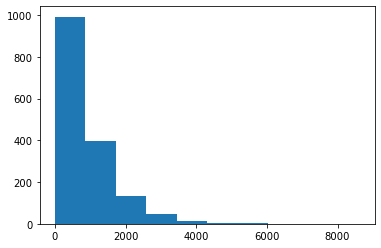

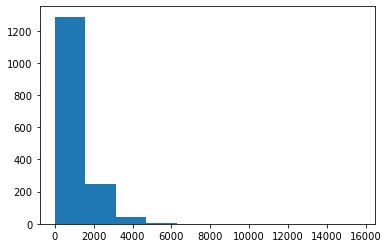

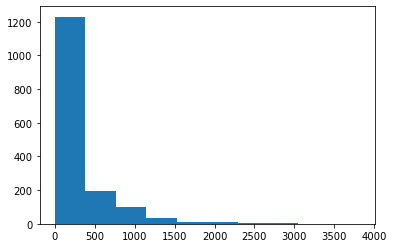

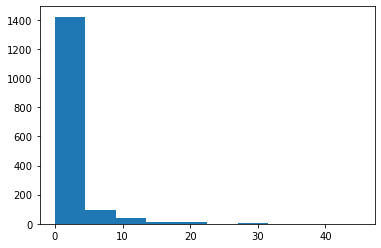

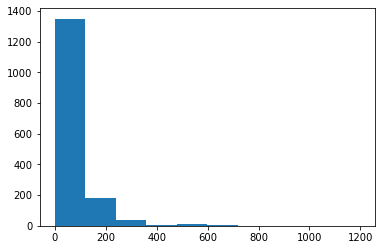

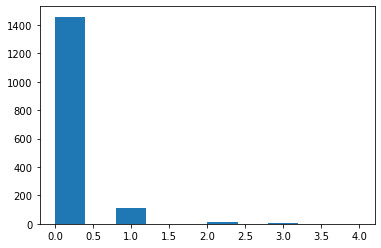

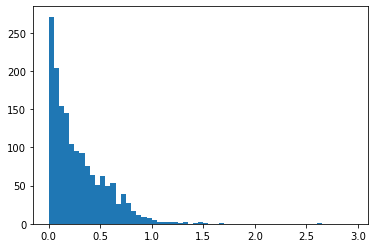

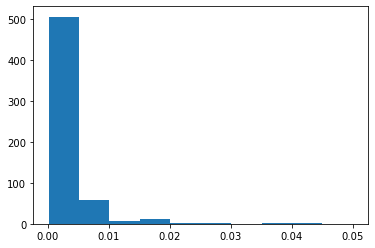

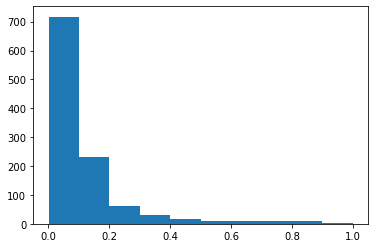

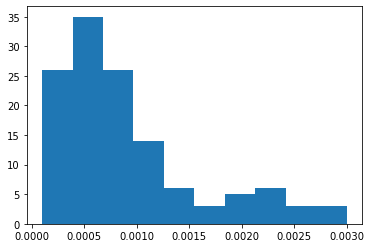

In [293]:


###########################################
# convert nominal to categorial


#check the range for facility lat
plt.gcf().set_size_inches(10 ,5)
plt.hist(mydata_convert['facility_lat'])
plt.show()

(mydata_convert[(mydata_convert['facility_lat'] > 25) & (mydata_convert['facility_lat'] < 35)]['facility_lat'] > 34 ).sum()

#18 - 25
#25 - 35
#35 - 45
#45 - 50
#50 - up


#facility lng
plt.hist(mydata_convert['facility_lng'])
plt.show()

mydata_convert[mydata_convert['facility_lng'] < -125]['facility_lng']
mydata_convert['facility_lng'].min()
#-165.4 - -125

mydata_convert[(mydata_convert['facility_lng'] > -125) & (mydata_convert['facility_lng'] < -100)]['facility_lng']
#-125 - -100

mydata_convert[(mydata_convert['facility_lng'] > -100) & (mydata_convert['facility_lng'] < -80)]['facility_lng']
#-100 - -80

mydata_convert['facility_lng'].max()
#-80 - -66.1


#fuctions for convertion the values
def lat (num):
    if num < 25:
        return '15 - 25'
    elif num < 35:
        return '25 - 35'
    elif num < 45:
        return '35 - 45'
    elif num < 50:
        return '45 - 50'
    else:
        return '50 - 65'
    
def lng (num):
    if num < -125:
        return '-165 _ -125'
    elif num < -100:
        return '-125 _ -100'
    elif num < -80:
        return '-100 _ -80'
    else:
        return '-80 _ -66'
    
mydata_convert['facility_lat'] = mydata_convert['facility_lat'].apply(lat)
mydata_convert['facility_lng'] = mydata_convert['facility_lng'].apply(lng)


#latest inmate population
plt.hist(mydata_convert['latest_inmate_population'])
plt.show()

#max_inmate_population_2020
plt.hist(mydata_convert['max_inmate_population_2020'])
plt.show()

#total_inmate_cases
plt.hist(mydata_convert['total_inmate_cases'])
plt.show()

#total_inmate_deaths
plt.hist(mydata_convert['total_inmate_deaths'])
plt.show()

#total_officer_cases
plt.hist(mydata_convert['total_officer_cases'])
plt.show()

#total_officer_deaths
plt.hist(mydata_convert['total_officer_deaths'])
plt.show()


def latest_max (num):
    if num < 1000:
        return '0 - 1000'
    elif num < 2000:
        return '1000 - 2000'
    elif num < 3000:
        return '2000 - 3000'
    elif num < 4000:
        return '3000 - 4000'
    else:
        return '4000 - up'

    
def total_cases (num):
    if num < 400:
        return '0 - 400'
    elif num < 800:
        return '400 - 800'
    elif num < 1200:
        return '800 - 1200'
    elif num < 1500:
        return '1200 - 1500'
    else:
        return '1500 - up'

    
def total_deaths (num):
    if num < 5:
        return '0 _ 5'
    elif num < 10:
        return '5 _ 10'
    elif num < 15:
        return '10 _ 15'
    else:
        return '15 _ up'

    
def total_cases_officer (num):
    if num < 100:
        return '0 - 100'
    elif num < 220:
        return '100 - 220'
    elif num < 380:
        return '220 - 380'
    else:
        return '380 - up'

    
def total_deaths_officer (num):
    if num == 0:
        return '0'
    elif num == 1:
        return '1'
    elif num == 2:
        return '2'
    else:
        return '3 - up'

mydata_convert['latest_inmate_population'] = mydata_convert['latest_inmate_population'].apply(latest_max)
mydata_convert['max_inmate_population_2020'] = mydata_convert['max_inmate_population_2020'].apply(latest_max)
mydata_convert['total_inmate_cases'] = mydata_convert['total_inmate_cases'].apply(total_cases)
mydata_convert['total_inmate_deaths'] = mydata_convert['total_inmate_deaths'].apply(total_deaths)
mydata_convert['total_officer_cases'] = mydata_convert['total_officer_cases'].apply(total_cases_officer)
mydata_convert['total_officer_deaths'] = mydata_convert['total_officer_deaths'].apply(total_deaths_officer)


#ratio_cases_inmate
plt.hist(mydata_convert['ratio_cases_inmate'] , bins = np.arange(0 , 3 , 0.05))
plt.show()

#ratio_deaths_inmate
plt.hist(mydata_convert['ratio_deaths_inmate'] , range = (0.0001,0.05))
plt.show()

#ratio_cases_officer
plt.hist(mydata_convert['ratio_cases_officer'] , range = (0.001 , 1))
plt.show()

#ratio_deaths_officer
plt.hist(mydata_convert['ratio_deaths_officer'] , range = (0.0001 , 0.003))
plt.show()



def ratio_inmate_cases (num):
    if num < 0.2:
        return '0 - 0.2'
    elif num < 0.4:
        return '0.2 - 0.4'
    elif num < 0.6:
        return '0.4 - 0.6'
    elif num < 0.8:
        return '0.6 - 0.8'
    elif num < 1:
        return '0.8 - 1'
    else:
        return '1 - up'

def ratio_inmate_deaths (num):
    if num == 0.0:
        return '0'
    elif num < 0.001:
        return '0.0 - 0.001'
    elif num < 0.002:
        return '0.001 - 0.002'
    else:
        return '0.002 - up'


def ratio_officer_cases (num):
    if num == 0.0:
        return '0'
    elif num < 0.1:
        return '0.0 - 0.1'
    elif num < 0.2:
        return '0.1 - 0.2'
    elif num < 0.3:
        return '0.2 - 0.3'
    elif num < 0.6:
        return '0.3 - 0.6'
    else:
        return '0.6 - up'

    
def ratio_officer_deaths (num):
    if num == 0.0:
        return '0'
    elif num < 0.0005:
        return '0.0 - 0.0005'
    elif num < 0.001:
        return '0.0005 - 0.001'
    elif num < 0.002:
        return '0.001 - 0.002'
    elif num < 0.003:
        return '0.002 - 0.003'
    else:
        return '0.003 - up'

    
mydata_convert['ratio_cases_inmate'] = mydata_convert['ratio_cases_inmate'].apply(ratio_inmate_cases)
mydata_convert['ratio_deaths_inmate'] = mydata_convert['ratio_deaths_inmate'].apply(ratio_inmate_deaths)
mydata_convert['ratio_cases_officer'] = mydata_convert['ratio_cases_officer'].apply(ratio_officer_cases)
mydata_convert['ratio_deaths_officer'] = mydata_convert['ratio_deaths_officer'].apply(ratio_officer_deaths)

